# IoMT Cyber-Medical Fusion Framework

Unified notebook combining:
1. Security module (CICIoMT2024)
2. Physiological module (VitalDB, replacing MIMIC-IV Demo)
3. Fusion and evaluation framework.

All original comments are preserved; only the physiological data-loading step was refactored to use VitalDB.

## 1. Security Module (original notebook `01_security_module.ipynb`)

In [1]:
# ==============================================================================
# STEP 0: ENVIRONMENT SETUP
# ==============================================================================

# --- 1. Mount Google Drive ---
# This command connects your Colab notebook to your Google Drive.
# You will be prompted to authorize the connection.
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# --- 2. Install necessary libraries (if not already installed) ---
!pip install xgboost shap -q

print("Setup complete. You can now proceed with Step 1.")

Mounted at /content/drive
Google Drive mounted successfully!
Setup complete. You can now proceed with Step 1.


In [2]:
# ==============================================================================
# STEP 1: LOAD, MERGE, AND OPTIMIZE A MULTI-FILE DATASET
# ==============================================================================
import pandas as pd
import numpy as np
import os
import glob
import gc # Garbage Collector interface

# --- Helper function to reduce memory usage ---
def reduce_mem_usage(df, verbose=True):
    """
    Iterates through all the columns of a dataframe and modifies the data type
    to reduce memory usage.
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print(f'Mem. usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

# --- 1. Define the exact path to your training data folder ---
train_folder_path = '/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/train_data_CICIoMT2024/train'

# --- 2. Get a list of all CSV files in the folder ---
print(f"Searching for CSV files in: {train_folder_path}")
all_csv_files = glob.glob(os.path.join(train_folder_path, "*.csv"))

if not all_csv_files:
    print(f"ERROR: No CSV files found in the specified directory.")
    print("Please check that the path is correct and the files have been uploaded.")
else:
    print(f"Found {len(all_csv_files)} CSV files to merge.")

    # --- 3. Loop through the files, read them, and add the 'label' column ---
    list_of_dataframes = []
    for f in all_csv_files:
        try:
            temp_df = pd.read_csv(f)
            file_name = os.path.basename(f)
            label_name = file_name.split('_train.pcap.csv')[0]
            if 'Benign' in label_name:
                label_name = 'Normal'
            temp_df['label'] = label_name
            list_of_dataframes.append(temp_df)
            print(f"Processed {file_name} -> assigned label '{label_name}'")
        except Exception as e:
            print(f"Error reading file {f}: {e}")

    # --- 4. Concatenate, clean up, and optimize ---
    if list_of_dataframes:
        print("\nMerging all dataframes...")
        df = pd.concat(list_of_dataframes, ignore_index=True)
        print("Merge complete!")

        # Clean up intermediate list to free up RAM
        del list_of_dataframes
        gc.collect()
        print("Intermediate memory freed.")

        # === APPLY MEMORY OPTIMIZATION ===
        print("\nOptimizing memory usage of the final dataframe...")
        df = reduce_mem_usage(df)

        # --- 5. Final check and shuffle ---
        print("\n--- Info on the final, optimized dataframe ---")
        display(df.info(memory_usage='deep'))

        print("\n--- Class distribution in the final dataframe ---")
        display(df['label'].value_counts())

        # Shuffle the dataframe
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        print("\nFinal dataframe has been shuffled.")

        print("\n--- First 5 rows of the final dataframe ---")
        display(df.head())
    else:
        print("No dataframes were loaded. Please check the source files.")

Searching for CSV files in: /content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/train_data_CICIoMT2024/train
Found 51 CSV files to merge.
Processed TCP_IP-DoS-ICMP3_train.pcap.csv -> assigned label 'TCP_IP-DoS-ICMP3'
Processed TCP_IP-DDoS-ICMP7_train.pcap.csv -> assigned label 'TCP_IP-DDoS-ICMP7'
Processed MQTT-DDoS-Connect_Flood_train.pcap.csv -> assigned label 'MQTT-DDoS-Connect_Flood'
Processed TCP_IP-DoS-ICMP4_train.pcap.csv -> assigned label 'TCP_IP-DoS-ICMP4'
Processed TCP_IP-DDoS-ICMP8_train.pcap.csv -> assigned label 'TCP_IP-DDoS-ICMP8'
Processed TCP_IP-DoS-TCP3_train.pcap.csv -> assigned label 'TCP_IP-DoS-TCP3'
Processed TCP_IP-DoS-ICMP1_train.pcap.csv -> assigned label 'TCP_IP-DoS-ICMP1'
Processed MQTT-DoS-Publish_Flood_train.pcap.csv -> assigned label 'MQTT-DoS-Publish_Flood'
Processed TCP_IP-DDoS-UDP1_train.pcap.csv -> assigned label 'TCP_IP-DDoS-UDP1'
Processed TCP_IP-DoS-SYN3_train.pcap.csv -> assigned label 'TCP_IP-DoS-SYN3'
Processed TCP_IP-DDoS-UDP6_train.pcap.csv

None


--- Class distribution in the final dataframe ---


,count
label,
TCP_IP-DDoS-UDP2,207295
TCP_IP-DDoS-UDP3,206604
TCP_IP-DDoS-UDP4,206343
TCP_IP-DDoS-UDP1,206170
TCP_IP-DDoS-UDP5,205507
TCP_IP-DDoS-UDP8,204105
TCP_IP-DDoS-TCP3,204075
TCP_IP-DDoS-SYN2,203669
TCP_IP-DDoS-TCP1,202311



Final dataframe has been shuffled.

--- First 5 rows of the final dataframe ---


,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,54.000000,6.00,64.0,0.041283,0.041283,0.0,0.0,1.0,0.0,0.0,...,0.000000,54.000000,84674552.0,9.5,10.392304,0.000000,0.000000,0.00,141.550003,TCP_IP-DoS-SYN4
1,54.000000,6.00,64.0,4.324057,4.324057,0.0,0.0,0.0,0.0,0.0,...,0.000000,54.000000,84670744.0,9.5,10.392304,0.000000,0.000000,0.00,141.550003,TCP_IP-DoS-TCP1
2,15.140000,1.05,64.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,16.893538,56.720001,84696984.0,9.5,9.497465,24.002483,5766.878418,0.05,141.550003,TCP_IP-DDoS-ICMP1
3,54.000000,6.00,64.0,5.374649,5.374649,0.0,0.0,0.0,0.0,0.0,...,0.000000,54.000000,84696112.0,9.5,10.392304,0.000000,0.000000,0.00,141.550003,TCP_IP-DDoS-TCP3
4,110.239998,6.00,64.0,0.487126,0.487126,0.0,0.0,1.0,0.0,0.0,...,0.000000,54.000000,84674672.0,9.5,10.392304,0.000000,0.000000,0.00,141.550003,TCP_IP-DoS-SYN3


In [3]:
# ==============================================================================
# SAVE THE MERGED SECURITY DATAFRAME
# Run this cell in your security notebook after the data has been loaded and merged
# ==============================================================================

# Ensure the final merged dataframe 'df' exists
if 'df' in locals():
    # Define the path where the file will be saved
    save_path = '/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/merged_ciciomt_data.parquet'

    # Save the dataframe to a Parquet file
    print(f"Saving the merged security dataframe to {save_path}...")
    df.to_parquet(save_path)
    print("Save complete!")
else:
    print("ERROR: Dataframe 'df' not found. Please run the data loading and merging step first.")

Saving the merged security dataframe to /content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/merged_ciciomt_data.parquet...
Save complete!


In [4]:
# ==============================================================================
# STEP 2-A (MODIFIED FOR BINARY TEST): PREPROCESSING JUST FOR FEATURE VALIDATING
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

if 'df' in locals():
    print("Starting data preprocessing for BINARY classification...")

    # --- Pulizia e encoding iniziale (rimane uguale) ---
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.select_dtypes(include=np.number).mean(), inplace=True)
    label_encoder = LabelEncoder()
    df['label_encoded'] = label_encoder.fit_transform(df['label'])
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    # --- Separazione Feature/Target e rimozione colonne (rimane uguale) ---
    X = df.select_dtypes(include=np.number).drop(['label_encoded'], axis=1)
    cols_to_drop = [
        'Protocol Type', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC',
        'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC'
    ]
    existing_cols_to_drop = [col for col in cols_to_drop if col in X.columns]
    if existing_cols_to_drop:
        X = X.drop(columns=existing_cols_to_drop)


    #/!\ BINARY MODE: We create a binary target: 0 -> 'Normal', 1 -> 'Attack'
    normal_label_code = label_mapping['Normal']
    y_binary = np.where(df['label_encoded'] == normal_label_code, 0, 1)
    y = y_binary # Usiamo il nuovo target binario
    print(f"-> Created a new BINARY target: 0 = Normal, 1 = Attack")

    # --- Scaling ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )
    print("-> Data prepared for binary classification.")

else:
    print("ERROR: Dataframe 'df' not found.")

Starting data preprocessing for BINARY classification...
-> Created a new BINARY target: 0 = Normal, 1 = Attack
-> Data prepared for binary classification.


In [5]:
# ==============================================================================
# STEP 2-B: PREPROCESSING FOR GROUPED CLASSES
# ==============================================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# We make sure that 'df' and 'X' still exist
if 'df' in locals() and 'X' in locals():
    print("Starting preprocessing for GROUPED classification...")

    # --- 1. Grouping all attack types ---
    def group_attack_labels(label):
        if 'Normal' in label:
            return 'Normal'
        if 'DDoS' in label:
            return 'DDoS'
        if 'DoS' in label:
            return 'DoS'
        if 'Recon' in label:
            return 'Recon'
        if 'ARP_Spoofing' in label:
            return 'Spoofing'
        if 'Malformed' in label:
            return 'Malformed'
        return 'Other'  # Fallback category, if needed

    # --- 2. Creating the new column with grouped labels ---
    df['grouped_label'] = df['label'].apply(group_attack_labels)
    print("-> Created a new 'grouped_label' column.")
    print("\n--- Distribution of the new grouped classes ---")
    display(df['grouped_label'].value_counts())

    # --- 3. Encoding the new grouped labels ---
    grouped_label_encoder = LabelEncoder()
    y_grouped = grouped_label_encoder.fit_transform(df['grouped_label'])

    # --- 4. Splitting into Training and Test sets ---
    # We reuse the same scaled features 'X_scaled' from binary classification
    X_train_grouped, X_test_grouped, y_train_grouped, y_test_grouped = train_test_split(
        X_scaled, y_grouped, test_size=0.3, random_state=42, stratify=y_grouped
    )
    print("\n-> Data split for grouped classification complete.")
    print(f"   Training set: {X_train_grouped.shape[0]} samples")
    print(f"   Test set: {X_test_grouped.shape[0]} samples")

else:
    print("ERROR: Make sure you have successfully executed the previous steps.")


Starting preprocessing for GROUPED classification...
-> Created a new 'grouped_label' column.

--- Distribution of the new grouped classes ---


,count
grouped_label,
DDoS,4980518
DoS,1862678
Normal,192732
Recon,103726
Spoofing,16047
Malformed,5130



-> Data split for grouped classification complete.
   Training set: 5012581 samples
   Test set: 2148250 samples


--- Training XGBoost Model for BINARY Classification ---
Starting training on GPU...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:10:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete.

--- Evaluating on Test Set ---


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [19:10:55] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Overall Accuracy: 99.93%
AUC-ROC Score: 1.0000

Detailed Classification Report (Normal vs Attack):
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99     57820
      Attack       1.00      1.00      1.00   2090430

    accuracy                           1.00   2148250
   macro avg       0.99      1.00      0.99   2148250
weighted avg       1.00      1.00      1.00   2148250



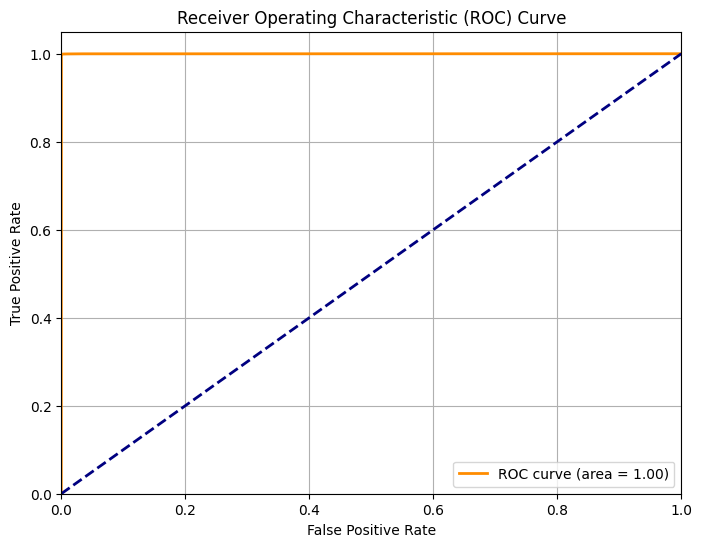

In [6]:
# ==============================================================================
# STEP 3-A (UPDATED WITH AUC-ROC): XGBOOST FOR BINARY CLASSIFICATION
# ==============================================================================
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Check if training data exists
if 'X_train' in locals() and 'y_binary' in locals():
    print("--- Training XGBoost Model for BINARY Classification ---")

    # Initialize the XGBoost classifier for binary classification
    xgb_model_binary = xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        device='cuda'  # Use GPU if available
    )

    print("Starting training on GPU...")
    xgb_model_binary.fit(X_train, y_train)  # Make sure y_train is the binary label set
    print("Training complete.")

    # --- Evaluation on the Test Set ---
    print("\n--- Evaluating on Test Set ---")
    y_pred_binary = xgb_model_binary.predict(X_test)
    y_pred_proba_binary = xgb_model_binary.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    print(f"Overall Accuracy: {accuracy_score(y_test, y_pred_binary) * 100:.2f}%")

    # --- AUC-ROC Calculation ---
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_binary)
    roc_auc = auc(fpr, tpr)
    print(f"AUC-ROC Score: {roc_auc:.4f}")

    print("\nDetailed Classification Report (Normal vs Attack):")
    print(classification_report(y_test, y_pred_binary, target_names=['Normal', 'Attack']))

    # --- Plotting ROC Curve ---
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

else:
    print("ERROR: Training data not found.")


--- Training and Evaluating XGBoost Model ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:10:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Overall Accuracy: 0.998857
Macro-Average AUC-ROC Score: 0.999959

Detailed Classification Report (6 Classes, High Precision):
              precision    recall  f1-score   support

        DDoS     0.9998    0.9999    0.9998   1494156
         DoS     0.9998    0.9994    0.9996    558803
   Malformed     0.9336    0.8311    0.8793      1539
      Normal     0.9793    0.9953    0.9873     57820
       Recon     0.9913    0.9769    0.9841     31118
    Spoofing     0.9079    0.8473    0.8765      4814

    accuracy                         0.9989   2148250
   macro avg     0.9686    0.9417    0.9544   2148250
weighted avg     0.9988    0.9989    0.9988   2148250



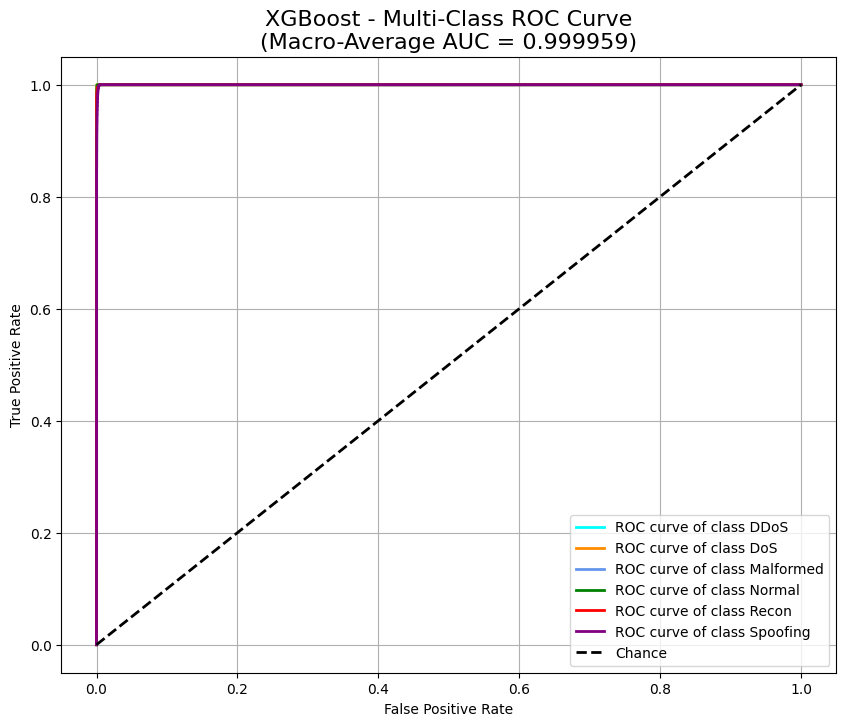

In [7]:
# ==============================================================================
# STEP 3-B (UPDATED WITH AUC-ROC): XGBOOST FOR GROUPED CLASSES
# ==============================================================================

import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Ensure the grouped training/test data exists
if 'X_train_grouped' in locals() and 'y_test_grouped' in locals():
    print("--- Training and Evaluating XGBoost Model ---")

    # Model definition
    xgb_model_grouped = xgb.XGBClassifier(
        objective='multi:softprob',
        use_label_encoder=False,
        eval_metric='mlogloss',
        device='cuda'
    )

    # Train the model
    xgb_model_grouped.fit(X_train_grouped, y_train_grouped)

    # --- Evaluation ---
    y_pred_grouped = xgb_model_grouped.predict(X_test_grouped)
    y_pred_proba_grouped = xgb_model_grouped.predict_proba(X_test_grouped)

    # Calculate the single, robust metric we want to display
    roc_auc_macro = roc_auc_score(y_test_grouped, y_pred_proba_grouped, multi_class='ovr', average='macro')

    print(f"\nOverall Accuracy: {accuracy_score(y_test_grouped, y_pred_grouped):.6f}")
    print(f"Macro-Average AUC-ROC Score: {roc_auc_macro:.6f}") # This is our key score

    print("\nDetailed Classification Report (6 Classes, High Precision):")
    print(classification_report(y_test_grouped, y_pred_grouped, target_names=grouped_label_encoder.classes_, digits=4))

    # --- Plotting ROC Curve with a single, aggregated score in the title ---
    y_test_binarized = label_binarize(y_test_grouped, classes=range(len(grouped_label_encoder.classes_)))
    n_classes = y_test_binarized.shape[1]
    fpr, tpr = dict(), dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_grouped[:, i])

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    plt.figure(figsize=(10, 8))

    for i, color in zip(range(n_classes), colors):
        # The label now only contains the class name for a cleaner legend
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {grouped_label_encoder.classes_[i]}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')

    # === KEY CHANGE: The main result is now in the title ===
    plt.title(f'XGBoost - Multi-Class ROC Curve\n(Macro-Average AUC = {roc_auc_macro:.6f})', fontsize=16)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

else:
    print("ERROR: Grouped training/test data not found.")

--- Generating Confusion Matrix ---


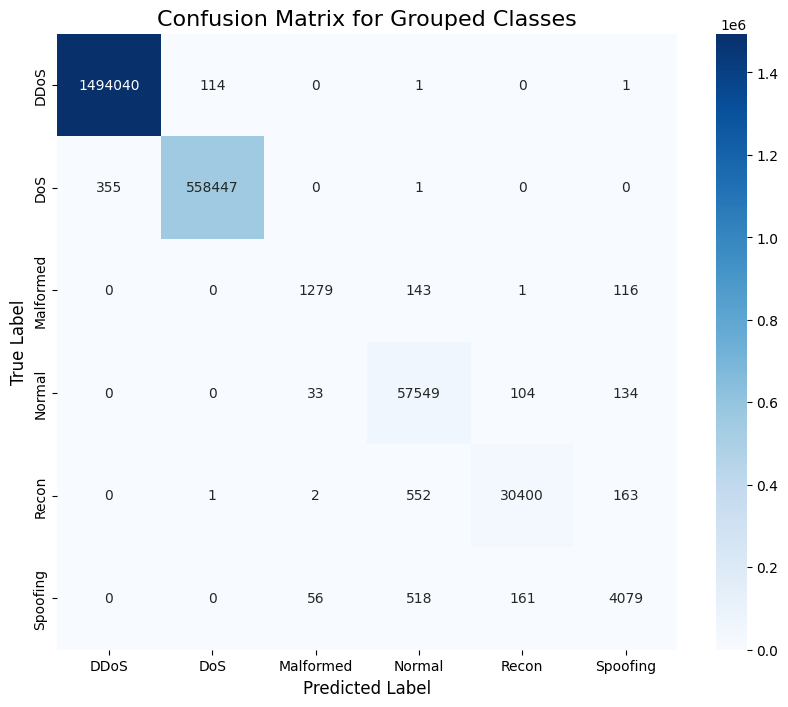


--- Generating Feature Importance Plot ---


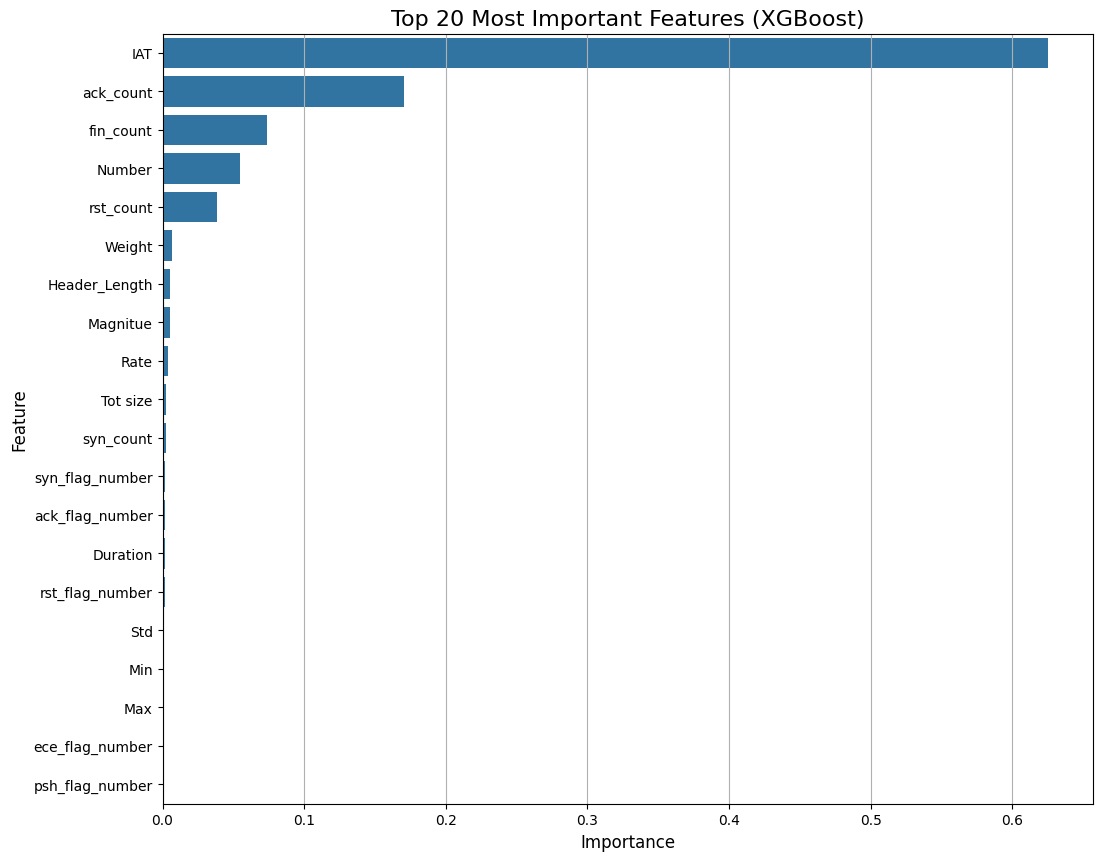


--- Generating SHAP Summary Plot (this may take a moment) ---


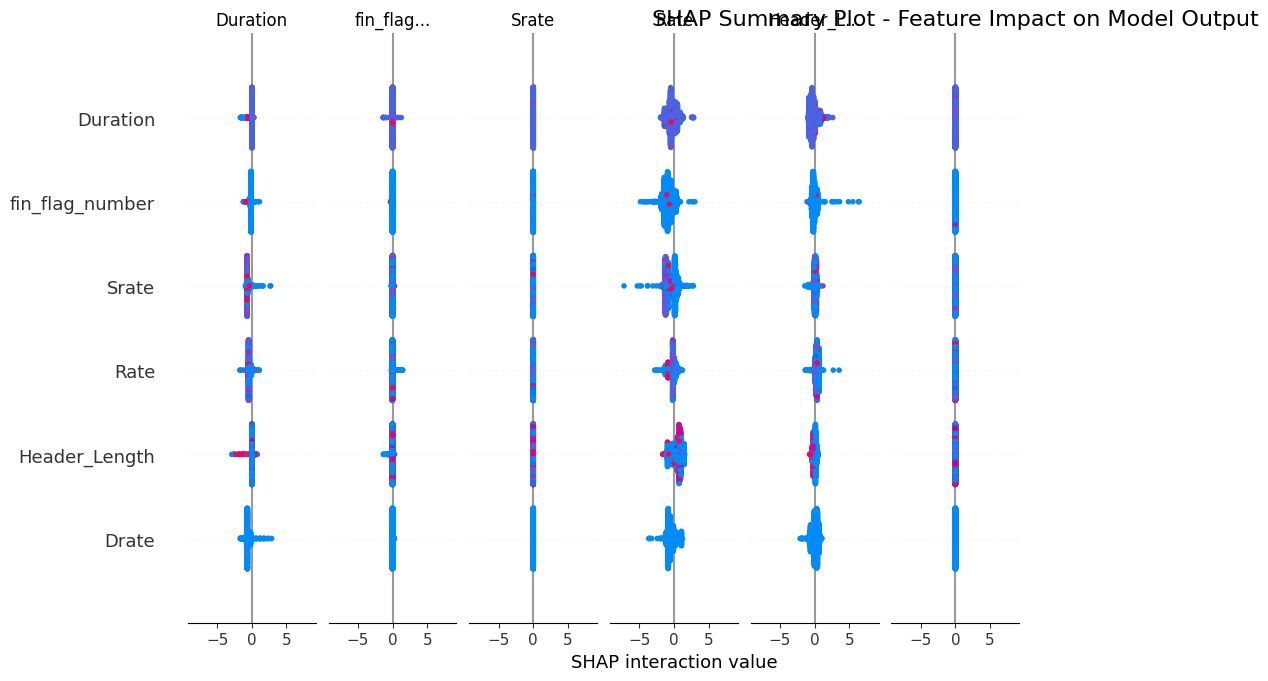

In [8]:
# ==============================================================================
# STEP 4: VISUALIZING MODEL PERFORMANCE AND INTERPRETABILITY
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import shap

# Ensure that the necessary model and data variables exist
if 'xgb_model_grouped' in locals() and 'X_test_grouped' in locals():

    # --- PLOT 1: CONFUSION MATRIX ---
    # This plot shows in detail where the model performs well and where it makes mistakes.
    print("--- Generating Confusion Matrix ---")

    cm = confusion_matrix(y_test_grouped, y_pred_grouped)
    class_names = grouped_label_encoder.classes_

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for Grouped Classes', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

    # --- PLOT 2: FEATURE IMPORTANCE ---
    # This plot shows which features the model considered most important for making its decisions.
    print("\n--- Generating Feature Importance Plot ---")

    feature_importances = xgb_model_grouped.feature_importances_
    # Create a DataFrame for easier plotting
    importance_df = pd.DataFrame({
        'Feature': X.columns, # Using column names from 'X' before scaling
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Display the top 20 most important features
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Most Important Features (XGBoost)', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x')
    plt.show()

    # --- PLOT 3: SHAP SUMMARY PLOT ---
    # This is the most advanced plot: it shows not only WHICH features are important,
    # but also HOW their values impact the prediction for each class.
    print("\n--- Generating SHAP Summary Plot (this may take a moment) ---")

    # Use a subset of the test set to speed up SHAP calculations
    X_test_sample_shap = pd.DataFrame(X_test_grouped[:2000], columns=X.columns)

    explainer = shap.TreeExplainer(xgb_model_grouped)
    shap_values = explainer.shap_values(X_test_sample_shap)

    # Plot the SHAP summary
    shap.summary_plot(shap_values, X_test_sample_shap,
                      class_names=class_names,
                      show=False)
    plt.title("SHAP Summary Plot - Feature Impact on Model Output", fontsize=16)
    plt.show()

else:
    print("ERROR: Make sure Step 3-B has been run successfully to generate the model and results.")

In [9]:
# ==============================================================================
# STEP 5: CROSS-VALIDATION FOR XGBOOST MODEL (SEQUENTIAL EXECUTION)
# ==============================================================================
from sklearn.model_selection import cross_val_score
import numpy as np
import xgboost as xgb

# Make sure the required data exists
if 'X_scaled' in locals() and 'y_grouped' in locals():
    print("--- Starting 5-Fold Cross-Validation (Sequential Mode) ---")
    print("This process will be slower but more memory-efficient.")

    # Define the model again to ensure it's a fresh instance
    xgb_model_for_cv = xgb.XGBClassifier(
        objective='multi:softprob',        # Multiclass classification
        use_label_encoder=False,
        eval_metric='mlogloss',
        tree_method='hist',                # Histogram-based (faster on large datasets)
        device='cuda'                      # Use GPU if available
    )

    # Perform 5-fold cross-validation sequentially
    # 'n_jobs=-1' was removed to avoid memory crashes
    scores = cross_val_score(
        estimator=xgb_model_for_cv,
        X=X_scaled,
        y=y_grouped,
        cv=5,
        scoring='accuracy'
    )

    print("\nCross-Validation complete.")
    print(f"Scores for each of the {len(scores)} folds: {scores}")
    print(f"Mean Accuracy: {np.mean(scores) * 100:.2f}%")
    print(f"Standard Deviation: {np.std(scores) * 100:.2f}%")

else:
    print("ERROR: Data for cross-validation not found. Please run the previous steps.")


--- Starting 5-Fold Cross-Validation (Sequential Mode) ---
This process will be slower but more memory-efficient.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:11:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:11:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:12:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:12:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:12:38] WARNING: /w


Cross-Validation complete.
Scores for each of the 5 folds: [0.99884441 0.99882625 0.99886605 0.99884441 0.99884161]
Mean Accuracy: 99.88%
Standard Deviation: 0.00%


--- Generating Individual SHAP Plots for Each Class (Corrected Slicing) ---



--- SHAP Summary Plot for Class: 'DDoS' ---


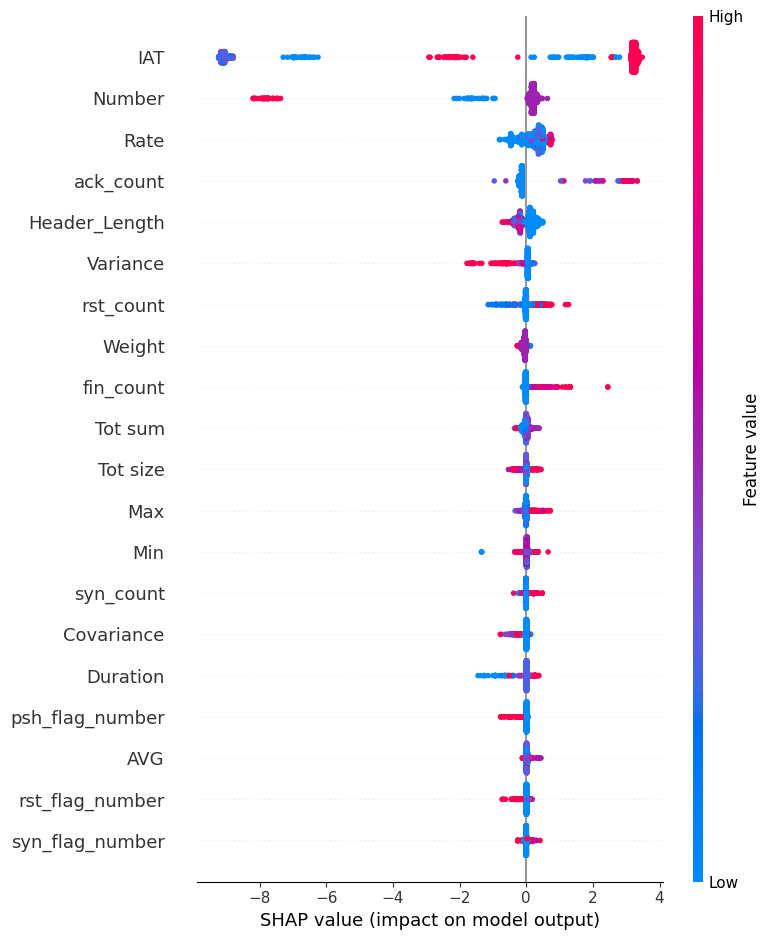


--- SHAP Summary Plot for Class: 'DoS' ---


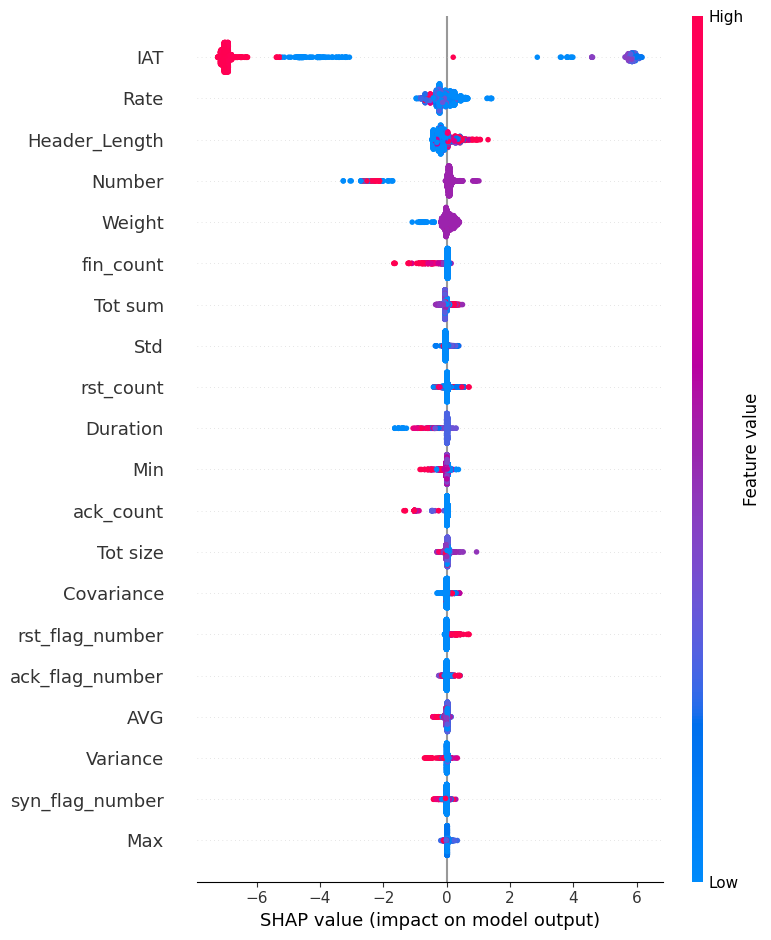


--- SHAP Summary Plot for Class: 'Malformed' ---


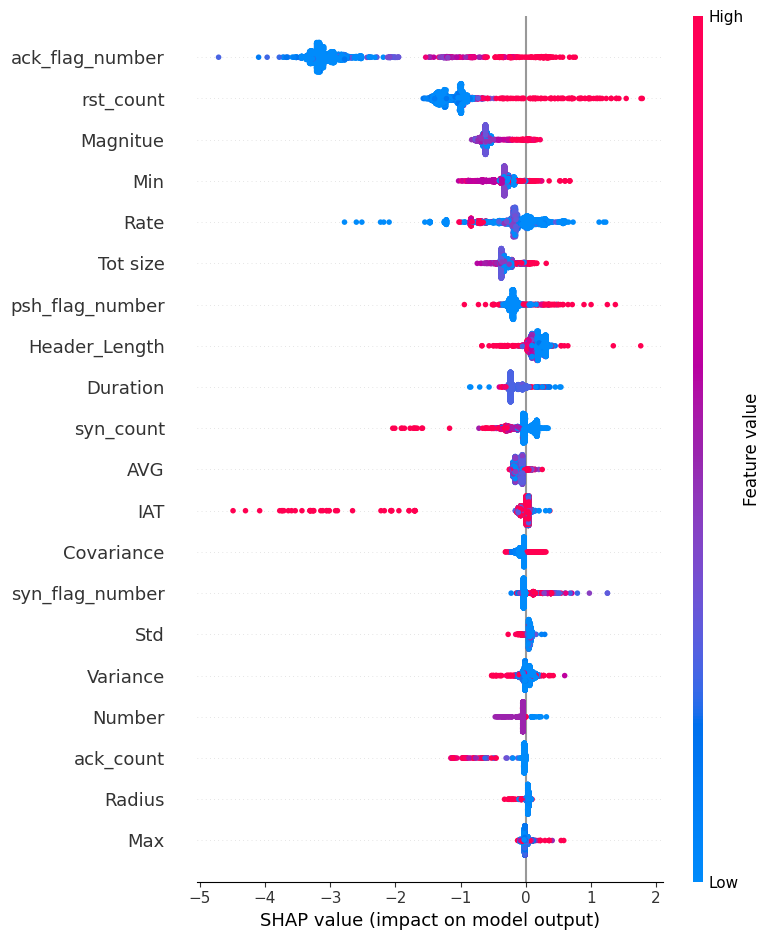


--- SHAP Summary Plot for Class: 'Normal' ---


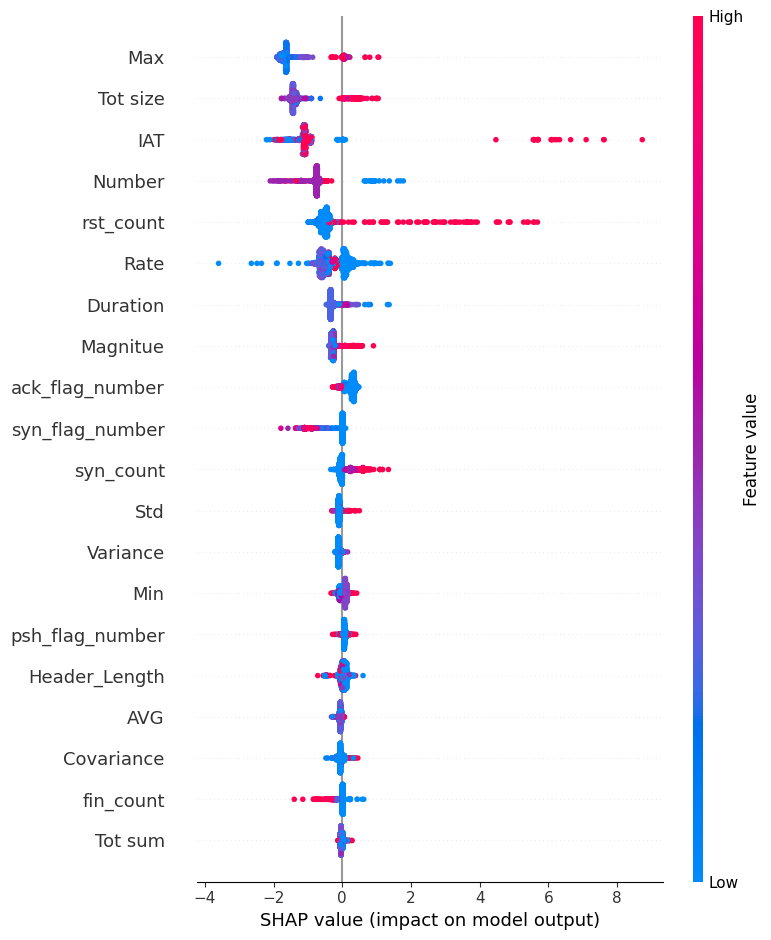


--- SHAP Summary Plot for Class: 'Recon' ---


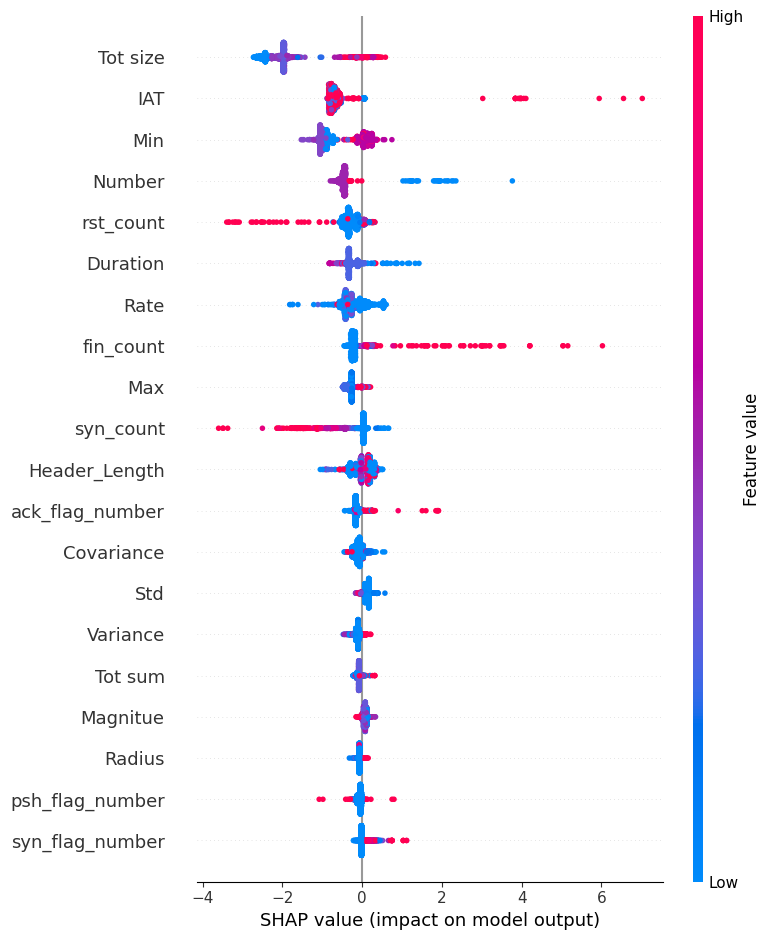


--- SHAP Summary Plot for Class: 'Spoofing' ---


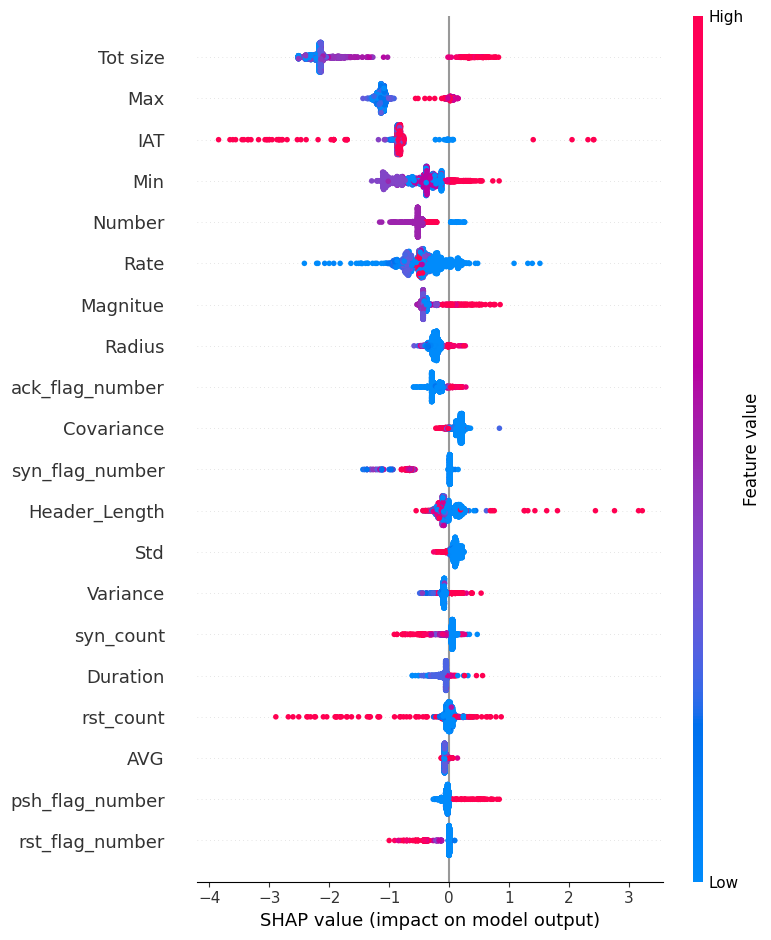

In [10]:
# ==============================================================================
# FINAL STEP: INTERPRETABILITY WITH SHAP
# ==============================================================================
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Ensure SHAP values have already been computed
if 'shap_values' in locals() and 'X_test_sample_shap' in locals():
    print("--- Generating Individual SHAP Plots for Each Class (Corrected Slicing) ---")

    # Initialize SHAP visualization
    shap.initjs()

    # Retrieve class names from our label encoder
    class_names = grouped_label_encoder.classes_

    # === LOOP TO GENERATE A SEPARATE PANEL FOR EACH CLASS ===
    for i, class_name in enumerate(class_names):

        print(f"\n--- SHAP Summary Plot for Class: '{class_name}' ---")


        # Select SHAP values for the i-th class using correct slicing for a 3D array
        shap.summary_plot(
            shap_values[:, :, i],  # Select ALL samples, ALL features, for class i
            X_test_sample_shap,
            show=True
        )
        plt.show()

else:
    print("ERROR: Make sure SHAP values were computed successfully.")


--- Training Isolation Forest Model (Unsupervised) ---
Training will be performed on 134912 'Normal' samples.
Training complete.

--- Evaluating on Test Set (Normal vs. Attack) ---
Overall Accuracy: 65.87%
AUC-ROC Score: 0.9000

Detailed Classification Report (Normal vs Attack):
              precision    recall  f1-score   support

      Normal       0.07      0.88      0.12     57820
      Attack       0.99      0.65      0.79   2090430

    accuracy                           0.66   2148250
   macro avg       0.53      0.77      0.45   2148250
weighted avg       0.97      0.66      0.77   2148250



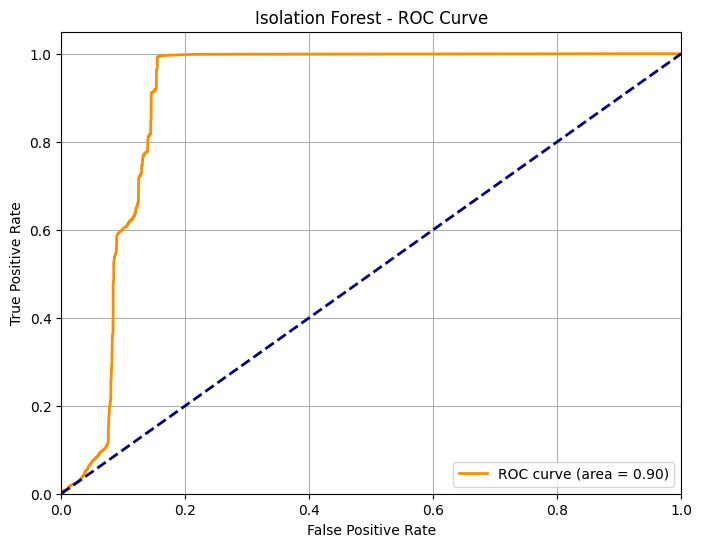

In [11]:
# ==============================================================================
# STEP 6: ISOLATION FOREST WITH VALID PARAMETERS AND AUC-ROC (First TEST, NOT SO GOOD!!)
# ==============================================================================
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Make sure training data is available
if 'X_train' in locals() and 'y_train' in locals():
    print("--- Training Isolation Forest Model (Unsupervised) ---")

    # The binary target is: 0 = Normal, 1 = Attack
    y_binary_train = np.where(y_train == 0, 0, 1)  # Ensure binary target for training
    X_train_normal_iso = X_train[y_binary_train == 0]  # Use only "Normal" samples for training
    print(f"Training will be performed on {X_train_normal_iso.shape[0]} 'Normal' samples.")

    # Define and train the model
    # === FIX: 'contamination' must be <= 0.5. Use 'auto' to let the model decide ===
    iso_forest = IsolationForest(
        n_estimators=100,
        contamination='auto',  # Let the model determine the contamination threshold
        random_state=42,
        n_jobs=-1
    )
    iso_forest.fit(X_train_normal_iso)
    print("Training complete.")

    # --- Evaluation on the Test Set ---
    # Get the anomaly decision scores
    decision_scores = iso_forest.decision_function(X_test)
    y_pred_proba_iso = -decision_scores  # Higher score means more likely to be an anomaly

    # Get binary predictions
    y_pred_iso_raw = iso_forest.predict(X_test)
    y_pred_iso = np.where(y_pred_iso_raw == 1, 0, 1)  # 1 → Normal (0), -1 → Anomaly (1)

    y_test_binary_iso = np.where(y_test == 0, 0, 1)

    print("\n--- Evaluating on Test Set (Normal vs. Attack) ---")
    print(f"Overall Accuracy: {accuracy_score(y_test_binary_iso, y_pred_iso) * 100:.2f}%")

    # --- AUC-ROC Calculation ---
    fpr, tpr, _ = roc_curve(y_test_binary_iso, y_pred_proba_iso)
    roc_auc = auc(fpr, tpr)
    print(f"AUC-ROC Score: {roc_auc:.4f}")

    print("\nDetailed Classification Report (Normal vs Attack):")
    print(classification_report(y_test_binary_iso, y_pred_iso, target_names=['Normal', 'Attack']))

    # --- Plotting ROC Curve ---
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Isolation Forest - ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

else:
    print("ERROR: Binary data not found.")


--- Training Isolation Forest Model (Unsupervised) ---
Training complete.

--- Evaluating Model's Separation Capability ---
AUC-ROC Score: 0.9000


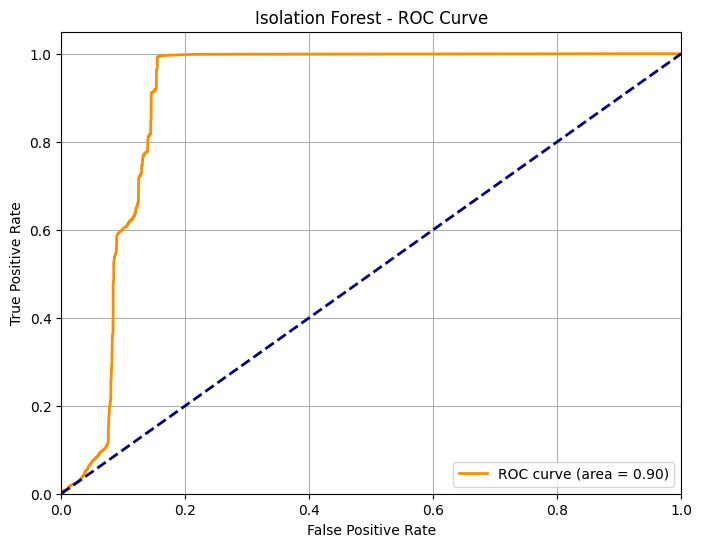


--- Optimizing Decision Threshold based on F1-Score ---
Optimal threshold found: 0.0722

--- Final Evaluation with Optimal Threshold ---
Overall Accuracy: 99.28%

Detailed Classification Report (Optimized):
              precision    recall  f1-score   support

      Normal       0.93      0.79      0.85     57820
      Attack       0.99      1.00      1.00   2090430

    accuracy                           0.99   2148250
   macro avg       0.96      0.89      0.93   2148250
weighted avg       0.99      0.99      0.99   2148250



In [12]:
# ==============================================================================
# FINAL STEP: COMPLETE EVALUATION OF ISOLATION FOREST
# ==============================================================================
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Make sure the necessary data is available
if 'X_train' in locals() and 'y_train' in locals():
    print("--- Training Isolation Forest Model (Unsupervised) ---")

    # Create binary labels: 0 = Normal, 1 = Attack
    y_binary_train = np.where(y_train == 0, 0, 1)
    X_train_normal_iso = X_train[y_binary_train == 0]

    # Define and train the model
    iso_forest = IsolationForest(
        n_estimators=100,
        contamination='auto',
        random_state=42,
        n_jobs=-1
    )
    iso_forest.fit(X_train_normal_iso)
    print("Training complete.")

    # --- Compute scores and prepare test data ---
    decision_scores = iso_forest.decision_function(X_test)
    y_pred_proba_iso = -decision_scores  # Higher score = more anomalous
    y_test_binary = np.where(y_test == 0, 0, 1)

    # --- 1. Compute and Plot the AUC-ROC Curve ---
    print("\n--- Evaluating Model's Separation Capability ---")
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba_iso)
    roc_auc = auc(fpr, tpr)
    print(f"AUC-ROC Score: {roc_auc:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Isolation Forest - ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # --- 2. Optimize the Decision Threshold based on F1-Score ---
    print("\n--- Optimizing Decision Threshold based on F1-Score ---")
    precisions, recalls, thresholds = precision_recall_curve(y_test_binary, y_pred_proba_iso)
    f1_scores = (2 * recalls * precisions) / (recalls + precisions + 1e-9)
    best_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_f1_idx]
    optimal_decision_threshold = -optimal_threshold  # Invert since we negated earlier

    print(f"Optimal threshold found: {optimal_decision_threshold:.4f}")

    # --- 3. Final Evaluation using the Optimized Threshold ---
    y_pred_optimal = np.where(decision_scores < optimal_decision_threshold, 1, 0)

    print("\n--- Final Evaluation with Optimal Threshold ---")
    print(f"Overall Accuracy: {accuracy_score(y_test_binary, y_pred_optimal) * 100:.2f}%")
    print("\nDetailed Classification Report (Optimized):")
    print(classification_report(y_test_binary, y_pred_optimal, target_names=['Normal', 'Attack']))

else:
    print("ERROR: Binary data not found.")


--- Generating SHAP Plot for Isolation Forest ---
This process will analyze what the model considers anomalous.


SHAP values calculated successfully.

--- Generating SHAP Summary Plot ---


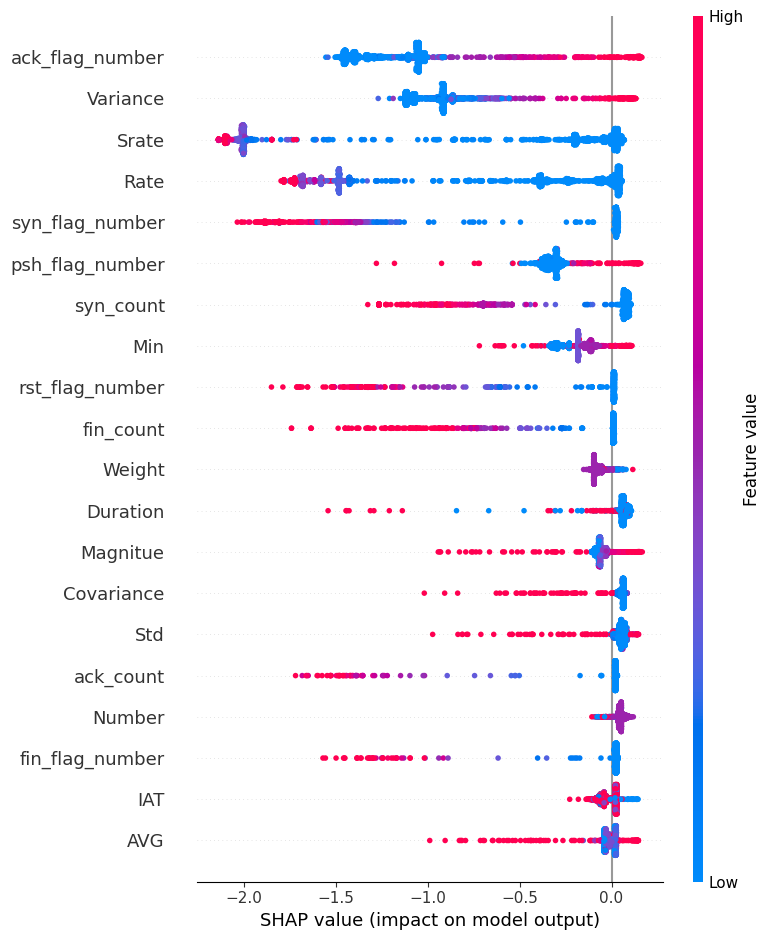

In [13]:
# ==============================================================================
# STEP 7: INTERPRETABILITY FOR ISOLATION FOREST (FINAL & SELF-CONTAINED)
# ==============================================================================
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Check that the required variables exist
if 'iso_forest' in locals() and 'X_test' in locals():
    print("--- Generating SHAP Plot for Isolation Forest ---")
    print("This process will analyze what the model considers anomalous.")

    # --- SAFETY BLOCK FOR FEATURE NAMES ---
    # Define correct feature names here to make the cell self-contained
    X_for_names = df.select_dtypes(include=np.number).drop(['label_encoded', 'label'], axis=1, errors='ignore')

    cols_to_drop = [
        'Protocol Type', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC',
        'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC'
    ]
    existing_cols_to_drop = [col for col in cols_to_drop if col in X_for_names.columns]

    if existing_cols_to_drop:
        X_for_names = X_for_names.drop(columns=existing_cols_to_drop)

    correct_feature_names = X_for_names.columns
    # ----------------------------------------------------

    # Prepare a sample of test data with the correct column names
    X_test_sample_shap_iso = pd.DataFrame(X_test[:2000], columns=correct_feature_names)

    # Initialize SHAP plotting (important in Colab or notebooks)
    shap.initjs()

    # Create a SHAP explainer and compute SHAP values
    iso_explainer = shap.TreeExplainer(iso_forest)
    iso_shap_values = iso_explainer.shap_values(X_test_sample_shap_iso)
    print("SHAP values calculated successfully.")

    # Generate the summary plot
    print("\n--- Generating SHAP Summary Plot ---")
    shap.summary_plot(iso_shap_values, X_test_sample_shap_iso)

else:
    print("ERROR: Make sure the required variables ('iso_forest', 'X_test', 'df') exist by running the previous steps.")


LSTM - TRAINING AND SEQUENTIAL WINDOWS

In [14]:
import numpy as np

def create_sequences(X_data, y_data, time_steps=10):
    """
    Create sequential series on 2D data.
    """
    Xs, ys = [], []
    for i in range(len(X_data) - time_steps):
        # Time window extraction
        v = X_data[i:(i + time_steps)]
        Xs.append(v)
        # Assigning labels on the last window
        ys.append(y_data[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

--- Calculating class weights... ---

--- Building Time-Series CNN-LSTM Model ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training CNN-LSTM Model with Class Weights ---
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4896/4896 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.5295 - loss: 0.7475
Epoch 2/5
4896/4896 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.6324 - loss: 0.5420
Epoch 3/5
4896/4896 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.6434 - loss: 0.5215
Epoch 4/5
4896/4896 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.6536 - loss: 0.5126
Epoch 5/5
4896/4896 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.6359 - loss: 0.5068

--- Full Evaluation on Test Set ---
2098/2098 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

Overall Accuracy: 64.24%
Macro-Average AUC-ROC Score: 0.9162

Detailed Classification Report (6 Classes):
              precision    recall  f1-score   support

        DDoS       0.85      0.61      0.71   1494144
         DoS       0.40      0.70      0.51    558795
   Malformed       0.15      0.90      0.26      1539
      Normal       0.98      0.82      0.89     57820
       Recon       0.99      0.91      0.95     31118
    Spoofing       0.30      0.60      0.40      4814

   

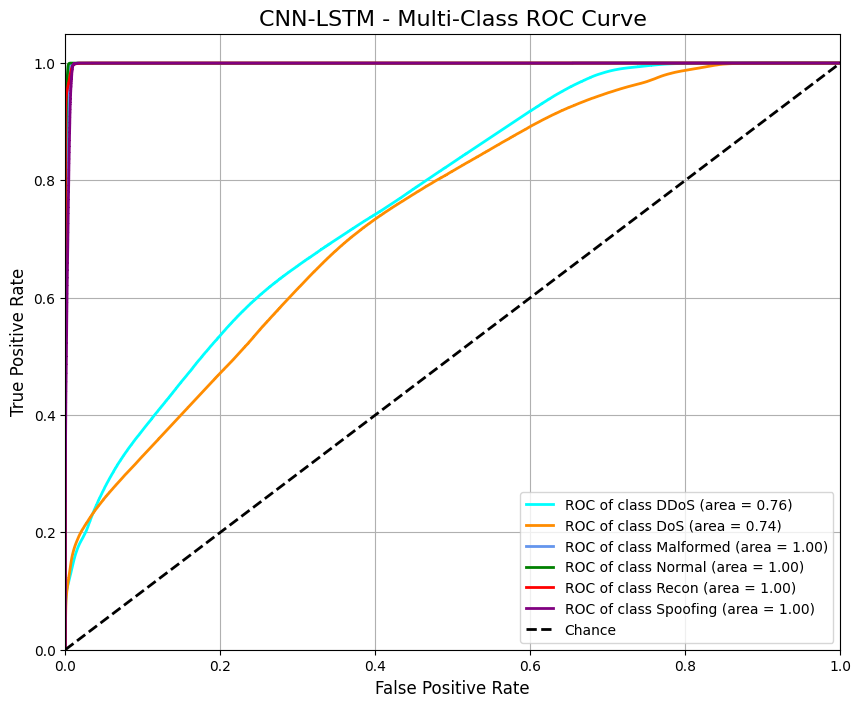

In [15]:
# ==============================================================================
# FINAL & COMPLETE: CNN-LSTM WITH BALANCED CLASSES AND AUC-ROC PLOT
# ==============================================================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.utils import Sequence
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

# --- Helper Functions and Classes ---
def create_sequences(X_data, y_data, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X_data) - time_steps):
        v = X_data[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y_data[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

class TimeSeriesGenerator(Sequence):
    def __init__(self, X_data, y_data, batch_size, time_steps):
        self.X_data = X_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.time_steps = time_steps
        self.indices = np.arange(len(X_data) - time_steps)
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_indices = self.indices[start_idx:end_idx]
        X_batch, y_batch = [], []
        for i in batch_indices:
            X_batch.append(self.X_data[i:(i + self.time_steps)])
            y_batch.append(self.y_data[i + self.time_steps - 1])
        return np.array(X_batch), np.array(y_batch)

# --- Training and Evaluation ---
if 'X_train_grouped' in locals():
    # 1. Calculate Class Weights
    print("--- Calculating class weights... ---")
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_grouped), y=y_train_grouped)
    class_weights = dict(enumerate(weights))

    # 2. Prepare Generators and Parameters
    TIME_STEPS = 20
    BATCH_SIZE = 1024
    training_generator = TimeSeriesGenerator(X_train_grouped, y_train_grouped, BATCH_SIZE, TIME_STEPS)
    test_generator = TimeSeriesGenerator(X_test_grouped, y_test_grouped, BATCH_SIZE, TIME_STEPS)

    n_features = X_train_grouped.shape[1]
    n_outputs = len(grouped_label_encoder.classes_)

    # 3. Build the Model
    print("\n--- Building Time-Series CNN-LSTM Model ---")
    cnn_lstm_model_balanced = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(TIME_STEPS, n_features), padding='same'),
        MaxPooling1D(pool_size=2),
        LSTM(100, activation='relu'),
        Dropout(0.5),
        Dense(n_outputs, activation='softmax')
    ])
    cnn_lstm_model_balanced.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # 4. Train the Model
    print("\n--- Training CNN-LSTM Model with Class Weights ---")
    history_balanced = cnn_lstm_model_balanced.fit(training_generator, epochs=5, verbose=1, class_weight=class_weights)

    # 5. Complete Evaluation on Test Set
    print("\n--- Full Evaluation on Test Set ---")
    y_pred_proba_cnn = cnn_lstm_model_balanced.predict(test_generator)
    y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)

    _, y_test_aligned = create_sequences(X_test_grouped, y_test_grouped, TIME_STEPS)
    y_test_final = y_test_aligned[:len(y_pred_cnn)]

    roc_auc_macro = roc_auc_score(y_test_final, y_pred_proba_cnn, multi_class='ovr', average='macro')

    print(f"\nOverall Accuracy: {accuracy_score(y_test_final, y_pred_cnn) * 100:.2f}%")
    print(f"Macro-Average AUC-ROC Score: {roc_auc_macro:.4f}")
    print("\nDetailed Classification Report (6 Classes):")
    print(classification_report(y_test_final, y_pred_cnn, target_names=grouped_label_encoder.classes_))

    # === BLOCCO GRAFICO AUC-ROC (AGGIUNTO) ===
    print("\n--- Generating Multi-Class ROC Curve Plot ---")
    y_test_binarized = label_binarize(y_test_final, classes=range(n_outputs))
    fpr, tpr, roc_auc_dict = dict(), dict(), dict()

    for i in range(n_outputs):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_cnn[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    plt.figure(figsize=(10, 8))

    for i, color in zip(range(n_outputs), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC of class {grouped_label_encoder.classes_[i]} (area = {roc_auc_dict[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('CNN-LSTM - Multi-Class ROC Curve', fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

else:
    print("ERROR: Grouped data not found. Please re-run the necessary preprocessing steps.")

In [16]:
# Save the trained XGBoost model
import joblib
joblib.dump(xgb_model_grouped, '/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/xgb_model_grouped.joblib')
print("XGBoost model saved successfully.")

XGBoost model saved successfully.


In [17]:
# ==========================================================
# SAVE SECURITY TEST DATA
# Run this cell once after preprocessing is complete
# ==========================================================
import numpy as np

# Check if the variables exist before saving
if 'X_test_grouped' in locals() and 'y_test_grouped' in locals():
    print("Saving security test data to files...")
    np.save('/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/X_test_grouped.npy', X_test_grouped)
    np.save('/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/y_test_grouped.npy', y_test_grouped)
    print("✅ Security test data saved successfully.")
else:
    print("❌ ERROR: 'X_test_grouped' or 'y_test_grouped' not found. Please run the preprocessing cells.")

Saving security test data to files...
✅ Security test data saved successfully.


## 2. Physiological Module (patched to use VitalDB instead of MIMIC-IV Demo)

In [18]:
# ==============================================================================
# STEP 0: ENVIRONMENT SETUP
# ==============================================================================

# --- 1. Mount Google Drive ---
# This command connects your Colab notebook to your Google Drive.
# You will be prompted to authorize the connection.
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# --- 2. Install necessary libraries (if not already installed) ---
!pip install xgboost shap vitaldb -q

print("Setup complete. You can now proceed with Step 1.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 148.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
Setup complete. You can now proceed with Step 1.


In [19]:
# ==========================
# T1_fix — Initialization
# ==========================
import vitaldb

# Candidate aliases for each vital. Track names vary across sites/devices,
# so we keep broad lists and pick the first available in each case.
CAND_HR = [
    "ECG_HR", "HR", "ECG/HR", "ECG_II_HR", "HR_ECG", "HR1"
]
CAND_SPO2 = [
    "SpO2", "SPO2", "PLETH_SPO2", "PLETH/SpO2", "Masimo_SpO2", "Saturation"
]
CAND_BP = [
    # Invasive arterial mean pressure (map/mean)
    "ART", "ABP", "ART_MBP", "ABP_M", "ART_Mean", "ABP_Mean", "ART_MAP", "ABP_MAP",
    # Non-invasive mean pressure
    "NBP_Mean", "NIBP_M", "NIBP_Mean", "NBP_MAP"
]

# Track sets to quickly "probe" VitalDB for case IDs.
# We try several common combinations; the first that returns non-empty wins.
PROBE_TRACK_SETS = [
    ["ECG_II", "ART"],
    ["ECG", "ART"],
    ["ECG_II", "ABP"],
    ["PLETH", "ART"],
    ["ECG", "PLETH"],
    ["ECG", "ABP"],
]

# Build `probe` by trying the above sets in order.
probe = None
for tracks in PROBE_TRACK_SETS:
    try:
        res = vitaldb.find_cases(tracks)
        if res and len(res) > 0:
            probe = res
            print(f"Probe OK with tracks {tracks} → {len(res)} case IDs found.")
            break
    except Exception as e:
        print(f"[Probe] Failed with {tracks}: {type(e).__name__}: {e}")

if probe is None:
    raise RuntimeError(
        "Could not build 'probe' with default track sets. "
        "Inspect a known case and extend CAND_* lists with the actual track names."
    )

# Optional helper to inspect the available track names for a case ID.
def inspect_tracks(case_id, limit=50):
    """
    Print the first `limit` track names for a given case, to help refine CAND_* lists.
    """
    vf = vitaldb.VitalFile(int(case_id))
    names = vf.get_track_names()
    print(f"Case {case_id} → {len(names)} tracks. First {min(limit, len(names))}:")
    for n in names[:limit]:
        print("  -", n)
    return names


Probe OK with tracks ['ECG_II', 'ART'] → 3644 case IDs found.


In [20]:
# ==============================================================================
# STEP 1  VitalDB end-to-end (single cell, strict validation)
# - Build probe, conservative smart-pick, Drive cache
# - Fast pass at 60 min, optional refine at 15 min
# - Strong data validation before counting a subject as valid
# - Parallel threads, early-stop, heartbeats & summaries
# ==============================================================================

import os, time, random, hashlib, threading
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
from itertools import islice

import numpy as np
import pandas as pd
import vitaldb
from tqdm.auto import tqdm

# ------------------------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------------------------
TARGET_N_CASES       = 1000
TARGET_SUBJECTS      = 250

# Fast + refine
FAST_SCAN_INTERVAL   = 60 * 60      # 60 min
REFINE_INTERVAL      = 15 * 60      # 15 min
ENABLE_FAST_SCAN     = True
ENABLE_REFINE_PASS   = False

# Parallelism & pacing
MAX_WORKERS          = 8
CASE_SOFT_TIMEOUT    = 25
PRINT_EVERY_SUBJECTS = 10
PRINT_EVERY_SECONDS  = 30
SUMMARY_EVERY_CASES  = 25
HEARTBEAT_SECONDS    = 15
SHUFFLE_CASES        = True

# Validation thresholds (tune for your dataset)
MIN_SAMPLES          = 6            # minimum rows after resampling
MIN_OVERLAP          = 4            # rows where HR & SpO2 both present
MIN_COVERAGE         = 0.25         # fraction of non-NaN per vital
MIN_INRANGE_FRAC_HR  = 0.70         # fraction of HR values within 20..250
MIN_INRANGE_FRAC_SPO2= 0.70         # fraction of SpO2 within 50..100
HR_MEDIAN_RANGE      = (30, 150)    # plausible median HR
SPO2_MEDIAN_RANGE    = (80, 100)    # plausible median SpO2

# Cache on Google Drive
PROJECT_SUBDIR       = "Conference_paper_ICCC_2026"
GDRIVE_BASES         = ["/content/drive/MyDrive", "/content/drive/MyDrive/Apps"]
CACHE_BACKEND        = "parquet"

# ------------------------------------------------------------------------------
# Cache helpers
# ------------------------------------------------------------------------------
def resolve_cache_dir():
    for base in GDRIVE_BASES:
        if os.path.isdir(base):
            return os.path.join(base, PROJECT_SUBDIR)
    fallback = os.path.join("/content", PROJECT_SUBDIR)
    print(
        f"[Warning] Google Drive not mounted.\n"
        f"Using local ephemeral cache: {fallback}\n"
        f"To mount in Colab:\n"
        f"  from google.colab import drive\n"
        f"  drive.mount('/content/drive')"
    )
    return fallback

CACHE_DIR = resolve_cache_dir()
os.makedirs(CACHE_DIR, exist_ok=True)
print("Cache dir →", os.path.abspath(CACHE_DIR))

def _cache_key(cid, tracks, interval):
    key_src = f"cid={cid}|tracks={','.join(tracks)}|interval={interval}"
    return f"case_{cid}_{hashlib.md5(key_src.encode('utf-8')).hexdigest()[:12]}"

def cache_paths(cid, tracks, interval):
    base = os.path.join(CACHE_DIR, _cache_key(cid, tracks, interval))
    return {"parquet": base + ".parquet", "pickle": base + ".pkl.gz", "tmp": base + ".tmp"}

def load_from_cache(cid, tracks, interval):
    paths = cache_paths(cid, tracks, interval)
    if os.path.exists(paths["parquet"]):
        try: return pd.read_parquet(paths["parquet"])
        except Exception: pass
    if os.path.exists(paths["pickle"]):
        try: return pd.read_pickle(paths["pickle"], compression="gzip")
        except Exception: pass
    return None

def save_to_cache(df, cid, tracks, interval):
    paths = cache_paths(cid, tracks, interval)
    tmp_path = paths["tmp"]
    try:
        if CACHE_BACKEND == "parquet":
            try:
                df.to_parquet(tmp_path)
                os.replace(tmp_path, paths["parquet"]); return
            except Exception:
                pass
        df.to_pickle(tmp_path, compression="gzip")
        os.replace(tmp_path, paths["pickle"])
    finally:
        if os.path.exists(tmp_path):
            try: os.remove(tmp_path)
            except Exception: pass

# ------------------------------------------------------------------------------
# Conservative smart selector (regex + negative filters)
# ------------------------------------------------------------------------------
def smart_pick(tracks, kind):
    """
    Heuristically pick one track of a given kind in {'hr','spo2','map'}.
    Conservative filtering to avoid alarms/derived/non-phys channels.
    """
    bad_tokens = ["alarm", "arr", "arrhythm", "resp", "rr", "quality", "flag", "beat-to-beat", "status"]
    cands = []
    for t in tracks:
        n = t.lower()
        if any(b in n for b in bad_tokens):
            continue

        if kind == "hr":
            if ("hr" in n or "heart" in n):
                score = 0
                if "ecg" in n: score += 4
                if "/hr" in n or n.endswith("_hr"): score += 2
                if "calc" in n or "derived" in n: score -= 1
                if "nibp" in n or "nbp" in n: score -= 2
                cands.append((score, t))

        elif kind == "spo2":
            if ("spo2" in n or "saturation" in n):
                score = 0
                if "pleth" in n: score += 1  # hint, but SpO2 is numeric channel
                if "masimo" in n or "mindray" in n or "solar8000" in n: score += 1
                if "calc" in n or "derived" in n: score -= 1
                cands.append((score, t))

        elif kind == "map":
            # prefer invasive mean first
            if ("art" in n or "abp" in n or "ibp" in n or "a-line" in n):
                if ("map" in n or "mean" in n or n.endswith("_m")):
                    score = 5
                    if "art" in n or "abp" in n: score += 2
                    cands.append((score, t))
            elif ("nibp" in n or "nbp" in n):
                if ("map" in n or "mean" in n or n.endswith("_m")):
                    score = 1
                    cands.append((score, t))

    if not cands:
        return None
    cands.sort(key=lambda x: (-x[0], len(x[1])))
    return cands[0][1]

# ------------------------------------------------------------------------------
# Strict validation of a per-case dataframe
# ------------------------------------------------------------------------------
def _frac_in_range(s, lo, hi):
    s = s.dropna()
    if s.empty: return 0.0
    return ((s >= lo) & (s <= hi)).mean()

def validate_case_df(df):
    """
    Return (True, info) if valid, else (False, reason).
    Requires: enough rows, coverage, overlap, plausible medians and in-range fractions.
    """
    cols = [c for c in ["Heart_Rate", "SpO2", "Arterial_BP_Mean"] if c in df.columns]
    if len(cols) < 2:
        return False, "too-few-cols"

    n = len(df)
    if n < MIN_SAMPLES:
        return False, "too-short"

    # coverage per vital
    cov_hr = df["Heart_Rate"].notna().mean() if "Heart_Rate" in df else 0.0
    cov_s  = df["SpO2"].notna().mean() if "SpO2" in df else 0.0
    if cov_hr < MIN_COVERAGE or cov_s < MIN_COVERAGE:
        return False, "insufficient-coverage"

    # overlap rows
    overlap = ((~df["Heart_Rate"].isna()) & (~df["SpO2"].isna())).sum()
    if overlap < MIN_OVERLAP:
        return False, "insufficient-overlap"

    # physiological sanity
    frac_hr_ok = _frac_in_range(df["Heart_Rate"], 20, 250) if "Heart_Rate" in df else 0.0
    frac_s_ok  = _frac_in_range(df["SpO2"], 50, 100) if "SpO2" in df else 0.0
    if frac_hr_ok < MIN_INRANGE_FRAC_HR or frac_s_ok < MIN_INRANGE_FRAC_SPO2:
        return False, "out-of-range"

    med_hr = np.nanmedian(df["Heart_Rate"].values) if "Heart_Rate" in df else np.nan
    med_s  = np.nanmedian(df["SpO2"].values) if "SpO2" in df else np.nan
    if not (HR_MEDIAN_RANGE[0] <= med_hr <= HR_MEDIAN_RANGE[1]):
        return False, "hr-median-implausible"
    if not (SPO2_MEDIAN_RANGE[0] <= med_s <= SPO2_MEDIAN_RANGE[1]):
        return False, "spo2-median-implausible"

    # optional: MAP sanity if present (do not fail hard; only tag)
    if "Arterial_BP_Mean" in df:
        frac_map_ok = _frac_in_range(df["Arterial_BP_Mean"], 20, 200)
        # we don't require MAP; if wildly off, we could drop the column:
        if frac_map_ok < 0.5:
            df["Arterial_BP_Mean"] = np.where(
                (df["Arterial_BP_Mean"] >= 20) & (df["Arterial_BP_Mean"] <= 200),
                df["Arterial_BP_Mean"],
                np.nan
            )

    # info summary to print on FOUND
    info = {
        "rows": n,
        "cov_hr": cov_hr,
        "cov_spo2": cov_s,
        "overlap": int(overlap),
        "med_hr": float(med_hr),
        "med_spo2": float(med_s),
        "frac_hr_ok": float(frac_hr_ok),
        "frac_spo2_ok": float(frac_s_ok),
    }
    return True, info

# ------------------------------------------------------------------------------
# Build `probe`
# ------------------------------------------------------------------------------
PROBE_TRACK_SETS = [
    ["ECG_II", "ART"], ["ECG", "ART"], ["ECG_II", "ABP"],
    ["PLETH", "ART"], ["ECG", "PLETH"], ["ECG", "ABP"],
]
probe = None
for tracks in PROBE_TRACK_SETS:
    try:
        res = vitaldb.find_cases(tracks)
        if res and len(res) > 0:
            probe = res
            print(f"Probe OK with tracks {tracks} → {len(res)} case IDs.")
            break
    except Exception as e:
        print(f"[Probe] Failed with {tracks}: {type(e).__name__}: {e}")
if probe is None:
    raise RuntimeError("Could not build 'probe'. Adjust PROBE_TRACK_SETS.")

all_case_ids = [int(x) for x in probe]
case_ids = all_case_ids[:TARGET_N_CASES]
if SHUFFLE_CASES:
    random.shuffle(case_ids)

print(f"Total cases from probe: {len(all_case_ids)}")
print(f"Will inspect up to: {len(case_ids)} cases\n")

# ------------------------------------------------------------------------------
# Per-case worker (parametric interval) + strict validation
# ------------------------------------------------------------------------------
def process_case_with_interval(cid, interval):
    """
    Return (cid, df_case or None, src_str, reason_or_info).
    On success: src_str in {'cache','download'} and reason_or_info is a dict with metrics.
    On skip: src_str is None and reason_or_info is a string reason.
    """
    try:
        vf = vitaldb.VitalFile(cid)
        case_tracks = vf.get_track_names()

        hr_track   = smart_pick(case_tracks, "hr")
        spo2_track = smart_pick(case_tracks, "spo2")
        map_track  = smart_pick(case_tracks, "map")

        if (hr_track is None) or (spo2_track is None):
            return cid, None, None, "skip-missing-tracks"

        selected = [t for t in [hr_track, spo2_track, map_track] if t is not None]

        # cache first
        df_case = load_from_cache(cid, selected, interval)
        src = "cache" if df_case is not None else "download"

        if df_case is None:
            t_start = time.time()
            df_case = vf.to_pandas(selected, interval=interval)
            if df_case is None or df_case.empty:
                return cid, None, None, "empty"

            rename_map = {hr_track: "Heart_Rate", spo2_track: "SpO2"}
            if map_track is not None:
                rename_map[map_track] = "Arterial_BP_Mean"
            df_case = df_case.rename(columns=rename_map)

            keep_cols = [c for c in ["Heart_Rate", "SpO2", "Arterial_BP_Mean"] if c in df_case.columns]
            if len(keep_cols) < 2:
                return cid, None, None, "too-few-cols"

            df_case = df_case.reset_index().rename(columns={"index": "charttime"})
            df_case["subject_id"] = cid
            df_case = df_case.dropna(subset=keep_cols, how="all")
            df_case = df_case[["subject_id", "charttime"] + keep_cols]
            if df_case.empty:
                return cid, None, None, "all-nan"

            slow = (time.time() - t_start) > CASE_SOFT_TIMEOUT

            # strict validation
            ok, info = validate_case_df(df_case)
            if not ok:
                return cid, None, None, info  # info is reason string

            # cache best-effort
            try:
                save_to_cache(df_case, cid, selected, interval)
            except Exception as ce:
                tqdm.write(f"[Cache] write failed for case {cid}: {type(ce).__name__}: {ce}")

            # tag slow if needed
            if slow and isinstance(info, dict):
                info = {**info, "slow": True}

            return cid, df_case, src, info

        else:
            # strict validation on cached data too
            ok, info = validate_case_df(df_case)
            if not ok:
                return cid, None, None, info
            return cid, df_case, src, info

    except Exception as e:
        return cid, None, None, f"error:{type(e).__name__}"

# ------------------------------------------------------------------------------
# Parallel pass with early-stop + strict validation
# ------------------------------------------------------------------------------
def run_parallel_pass(interval, target_subjects, tag="FAST"):
    found = []
    skip_counts = Counter()
    t0 = time.time()
    last_log_time = t0
    last_log_subjects = 0
    last_heartbeat = t0
    total = len(case_ids)
    cases_seen = 0
    stop_flag = threading.Event()

    def heartbeat():
        nonlocal last_heartbeat
        now = time.time()
        if (now - last_heartbeat) >= HEARTBEAT_SECONDS:
            pct = (cases_seen / max(1,total)) * 100.0
            top = ", ".join(f"{k}:{v}" for k,v in skip_counts.most_common(3)) or "—"
            tqdm.write(f"[Heartbeat] processed={cases_seen}/{total} ({pct:.1f}%) | valid={len(found)} | skips: {top}")
            last_heartbeat = now

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futures = {ex.submit(process_case_with_interval, cid, interval): cid for cid in case_ids}
        with tqdm(total=total, desc=f"{tag} pass (interval={interval//60}min) x{MAX_WORKERS}") as pbar:
            try:
                for fut in as_completed(futures):
                    if stop_flag.is_set():
                        break
                    cid = futures[fut]
                    cid_out, df_case, src, meta = fut.result()
                    pbar.update(1)
                    cases_seen += 1

                    if df_case is None:
                        reason = meta if isinstance(meta, str) else "unknown"
                        skip_counts[reason] += 1
                        if SUMMARY_EVERY_CASES and cases_seen % SUMMARY_EVERY_CASES == 0:
                            top = ", ".join(f"{k}:{v}" for k,v in skip_counts.most_common(6))
                            tqdm.write(f"[Summary] processed={cases_seen} | valid={len(found)} | skips: {top}")
                        heartbeat()
                        continue

                    found.append((cid_out, df_case))
                    # meta is dict with validation info
                    info = ", ".join([
                        f"rows={meta.get('rows')}",
                        f"cov_hr={meta.get('cov_hr'):.2f}",
                        f"cov_spo2={meta.get('cov_spo2'):.2f}",
                        f"overlap={meta.get('overlap')}",
                        f"med_hr={meta.get('med_hr'):.1f}",
                        f"med_spo2={meta.get('med_spo2'):.1f}",
                    ])
                    if meta.get("slow", False):
                        info += " | slow"
                    tqdm.write(f"[FOUND] subject_id={cid_out} | {info} | src={src} | total_valid={len(found)}")

                    now = time.time()
                    if len(found) >= target_subjects:
                        tqdm.write(f"\nReached target of {target_subjects} subjects – stopping early & cancelling remaining.")
                        stop_flag.set()
                        for f in futures:
                            if not f.done():
                                f.cancel()
                        break

                    by_subj = (PRINT_EVERY_SUBJECTS is not None and len(found) > 0 and
                               (len(found) - last_log_subjects) >= PRINT_EVERY_SUBJECTS)
                    by_sec  = (PRINT_EVERY_SECONDS is not None and (now - last_log_time) >= PRINT_EVERY_SECONDS)
                    if by_subj or by_sec:
                        elapsed = now - t0
                        rate = len(found) / elapsed if elapsed > 0 else 0.0
                        pct = (cases_seen / max(1,total)) * 100.0
                        tqdm.write(
                            f"[Progress] valid={len(found)}/{target_subjects} "
                            f"({len(found)/max(1,target_subjects):.0%}) | "
                            f"processed={cases_seen}/{total} ({pct:.1f}%) | "
                            f"elapsed={elapsed/60:.1f}m | rate={rate:.2f} subj/s"
                        )
                        last_log_time = now
                        last_log_subjects = len(found)
                    heartbeat()
            finally:
                ex.shutdown(cancel_futures=True)

    elapsed = time.time() - t0
    tqdm.write(f"[{tag}] Done in {elapsed/60:.1f} minutes. Found {len(found)} valid subjects.")
    return found, skip_counts

# ------------------------------------------------------------------------------
# RUN
# ------------------------------------------------------------------------------
if MAX_WORKERS <= 0:
    raise RuntimeError("Set MAX_WORKERS > 0 for the speed-optimized path.")

first_interval = FAST_SCAN_INTERVAL if ENABLE_FAST_SCAN else REFINE_INTERVAL
found_fast, skip_counts = run_parallel_pass(first_interval, TARGET_SUBJECTS, tag="FAST" if ENABLE_FAST_SCAN else "MAIN")

if len(found_fast) == 0:
    top = ", ".join(f"{k}:{v}" for k,v in skip_counts.most_common(10)) or "—"
    raise RuntimeError(f"No valid subjects found. Skip reasons: {top}")

df_wide = pd.concat([df for _, df in found_fast], ignore_index=True)
print(f"\nBuilt 'df_wide' (interval={first_interval//60}min) with shape: {df_wide.shape}")
print(df_wide.head())

# Optional refine at 15 min for only the found subjects
if ENABLE_REFINE_PASS and ENABLE_FAST_SCAN and (REFINE_INTERVAL != first_interval):
    tqdm.write("\n[REFINE] Re-fetching found subjects at 15-min interval…")
    subject_ids = [cid for cid, _ in found_fast]

    def refine_case(cid):
        _, df_case, src, meta = process_case_with_interval(cid, REFINE_INTERVAL)
        return cid, df_case, src, meta

    refined, skip_ref = [], Counter()
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futures = {ex.submit(refine_case, cid): cid for cid in subject_ids}
        for fut in tqdm(as_completed(futures), total=len(futures), desc=f"REFINE pass (interval={REFINE_INTERVAL//60}min)"):
            cid = futures[fut]
            cid_out, df_case, src, meta = fut.result()
            if df_case is None:
                reason = meta if isinstance(meta, str) else "unknown"
                skip_ref[reason] += 1
            else:
                tqdm.write(f"[REFINE-FOUND] subject_id={cid_out} | rows={len(df_case)} | src={src}")
                refined.append(df_case)

    if refined:
        df_wide = pd.concat(refined, ignore_index=True)
        print(f"[REFINE] Rebuilt 'df_wide' (interval={REFINE_INTERVAL//60}min) with shape: {df_wide.shape}")
        print(df_wide.head())
    else:
        top = ", ".join(f"{k}:{v}" for k,v in skip_ref.most_common(10)) or "—"
        tqdm.write(f"[REFINE] No subjects refined. Skip reasons: {top}")


Cache dir → /content/drive/MyDrive/Conference_paper_ICCC_2026
Probe OK with tracks ['ECG_II', 'ART'] → 3644 case IDs.
Total cases from probe: 3644
Will inspect up to: 1000 cases



FAST pass (interval=60min) x8:   0%|          | 0/1000 [00:00<?, ?it/s]

[Heartbeat] processed=2/1000 (0.2%) | valid=0 | skips: too-short:2
[FOUND] subject_id=499 | rows=6, cov_hr=1.00, cov_spo2=1.00, overlap=6, med_hr=93.5, med_spo2=99.0 | src=cache | total_valid=1
[Progress] valid=1/250 (0%) | processed=7/1000 (0.7%) | elapsed=0.6m | rate=0.03 subj/s
[Heartbeat] processed=8/1000 (0.8%) | valid=1 | skips: too-short:7
[FOUND] subject_id=164 | rows=7, cov_hr=1.00, cov_spo2=1.00, overlap=7, med_hr=109.0, med_spo2=100.0 | src=cache | total_valid=2
[Heartbeat] processed=14/1000 (1.4%) | valid=2 | skips: too-short:12
[Heartbeat] processed=18/1000 (1.8%) | valid=2 | skips: too-short:15, out-of-range:1
[Heartbeat] processed=21/1000 (2.1%) | valid=2 | skips: too-short:18, out-of-range:1
[FOUND] subject_id=19 | rows=8, cov_hr=1.00, cov_spo2=1.00, overlap=8, med_hr=66.5, med_spo2=100.0 | src=cache | total_valid=3
[Progress] valid=3/250 (1%) | processed=23/1000 (2.3%) | elapsed=1.8m | rate=0.03 subj/s
[FOUND] subject_id=1410 | rows=6, cov_hr=1.00, cov_spo2=1.00, overl

In [23]:
# ==============================================================================
# VITALDB - STEP 2: TIME-SERIES PREPROCESSING AND IMPUTATION
# ==============================================================================
from sklearn.preprocessing import StandardScaler

if 'df_wide' in locals():
    print("--- Starting time-series preprocessing ---")

    # 1. Convert 'charttime' column to datetime objects
    df_wide['charttime'] = pd.to_datetime(df_wide['charttime'])
    print("-> Converted 'charttime' to datetime objects.")

    # 2. Resample and impute data for each patient
    # We will process each patient individually to not mix their data
    processed_patients = []

    # Use .groupby() to iterate over each patient's data
    for patient_id, group in df_wide.groupby('subject_id'):
        # Set the time column as the index for time-based operations
        group = group.set_index('charttime').drop('subject_id', axis=1)

        # Resample to a fixed frequency (e.g., every 15 minutes) and take the mean
        # This creates a uniform timeline for all patients
        group_resampled = group.resample('15T').mean()

        # Impute missing values using forward-fill, then backward-fill
        group_imputed = group_resampled.fillna(method='ffill').fillna(method='bfill')

        # Add the patient_id back
        group_imputed['subject_id'] = patient_id

        processed_patients.append(group_imputed)

    # Concatenate all processed patient dataframes back into one
    df_processed = pd.concat(processed_patients).reset_index()
    print("-> Resampled to a 15-minute frequency and imputed missing values.")

    # 3. Handle any fully-NaN patients that might remain and scale features
    df_processed.dropna(inplace=True) # Drop patients with no measurements at all

    vital_cols = [col for col in df_processed.columns if col not in ['subject_id', 'charttime']]

    scaler = StandardScaler()
    df_processed[vital_cols] = scaler.fit_transform(df_processed[vital_cols])
    print("-> Scaled vital sign features.")

    # 4. Display final result
    print("\n--- Preprocessing complete. Data is now clean and uniform. ---")
    display(df_processed.info())
    display(df_processed.head())

else:
    print("ERROR: Wide-format dataframe 'df_wide' not found. Please run Step 1 successfully.")

--- Starting time-series preprocessing ---
-> Converted 'charttime' to datetime objects.


/tmp/ipython-input-220754220.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_resampled = group.resample('15T').mean()
/tmp/ipython-input-220754220.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group_imputed = group_resampled.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-220754220.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_resampled = group.resample('15T').mean()
/tmp/ipython-input-220754220.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group_imputed = group_resampled.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-220754220.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min'

-> Resampled to a 15-minute frequency and imputed missing values.
-> Scaled vital sign features.

--- Preprocessing complete. Data is now clean and uniform. ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   charttime   209 non-null    datetime64[ns]
 1   Heart_Rate  209 non-null    float32       
 2   SpO2        209 non-null    float32       
 3   subject_id  209 non-null    int64         
dtypes: datetime64[ns](1), float32(2), int64(1)
memory usage: 5.0 KB


/tmp/ipython-input-220754220.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_resampled = group.resample('15T').mean()
/tmp/ipython-input-220754220.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group_imputed = group_resampled.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-220754220.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_resampled = group.resample('15T').mean()
/tmp/ipython-input-220754220.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group_imputed = group_resampled.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-220754220.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min'

None

,charttime,Heart_Rate,SpO2,subject_id
0,1970-01-01,0.285259,1.190386,4
1,1970-01-01,0.152140,0.925588,10
2,1970-01-01,0.152140,0.248882,12
3,1970-01-01,-0.077792,-1.457591,17
4,1970-01-01,-1.781107,0.925588,19


In [26]:
#Save the fully processed VitalDB dataframe used by the AE
processed_clinical_path = "/content/drive/MyDrive/Conference_paper_ICCC_2026/vitaldb_df_processed_final.parquet"
df_processed.to_parquet(processed_clinical_path, index=False)
print("✅ Saved VitalDB processed clinical dataframe to:", processed_clinical_path)


✅ Saved VitalDB processed clinical dataframe to: /content/drive/MyDrive/Conference_paper_ICCC_2026/vitaldb_df_processed_final.parquet


In [27]:
# ==============================================================================
# SAVE THE PROCESSED DATAFRAME (Corrected Variable Name)
# ==============================================================================

# The variable created by our last preprocessing script is 'df_processed'
if 'df_processed' in locals():
    # Define the path where the file will be saved
    save_path = '/content/drive/MyDrive/Conference_paper_ICCC_2026/df_processed_final.parquet'

    # Save the dataframe to a Parquet file
    print(f"Saving the processed dataframe ('df_processed') to {save_path}...")
    df_processed.to_parquet(save_path)
    print("Save complete!")
else:
    print("ERROR: Dataframe 'df_processed' not found. Please ensure the preprocessing cell has been run successfully.")

Saving the processed dataframe ('df_processed') to /content/drive/MyDrive/Conference_paper_ICCC_2026/df_processed_final.parquet...
Save complete!


--- Preparing data for Autoencoder ---
Using vital columns for AE: ['Heart_Rate', 'SpO2']
Created 185 sequences of shape (24, 2)
Training data shape: (148, 24, 2)
Test data shape: (37, 24, 2)

--- Building LSTM Autoencoder Model ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 2)          │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,306 (196.51 KB)

 Trainable params: 50,306 (196.51 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Autoencoder on normal patterns ---
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - loss: 0.7804 - val_loss: 0.7519
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.7778 - val_loss: 0.7495
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7753 - val_loss: 0.7481
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7722 - val_loss: 0.7472
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7728 - val_loss: 0.7459
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7738 - val_loss: 0.7437
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7737 - val_loss: 0.7421
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7733 - val_loss: 0.7417
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7709 - val_loss: 0.7409
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7701 - val_loss: 0.7391

--- Detecting anomalies based on reconstruction error ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Reconstruction error thres

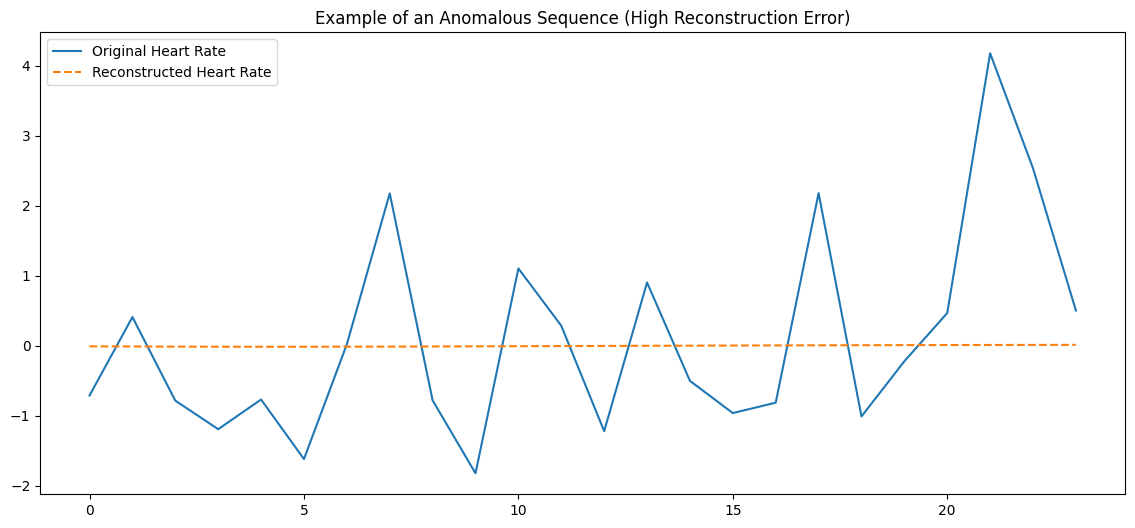

In [28]:
# ==============================================================================
# VITALDB - STEP 3: UNSUPERVISED ANOMALY DETECTION WITH LSTM AUTOENCODER
# (now using VitalDB-derived df_processed)
# ==============================================================================
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Helper Function to create time-series sequences ---
def create_sequences(X_data, y_data, time_steps=10):
    """Creates time-series sequences from 2D data."""
    Xs, ys = [], []
    for i in range(len(X_data) - time_steps):
        v = X_data[i:(i + time_steps)]
        Xs.append(v)
        # The y_data is just a placeholder here, not used for training
        ys.append(y_data[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

# --- Main Logic ---
if 'df_processed' in locals():
    # 1. Prepare Data for the Autoencoder
    print("--- Preparing data for Autoencoder ---")

    # Select only the vital sign columns for training
    # With VitalDB we may have fewer vital signs than the original MIMIC-IV demo.
    # We therefore select only the columns that are actually present in df_processed.
    candidate_vital_cols = [
        'Arterial_BP_Mean',
        'Heart_Rate',
        'SpO2',
        'Arterial_BP_Diastolic',
        'Arterial_BP_Systolic',
        'Respiratory_Rate',
        'Temperature_C',
    ]
    vital_cols = [c for c in candidate_vital_cols if c in df_processed.columns]
    print("Using vital columns for AE:", vital_cols)
    if len(vital_cols) == 0:
        raise RuntimeError(
            "No valid vital sign columns found in df_processed. "
            "Please check preprocessing / column names."
        )

    data_for_model = df_processed[vital_cols].values

    # Create sequences. We don't need the 'y' labels for autoencoder training.
    TIME_STEPS = 24  # Using a window of 24 samples (e.g., 6 hours if data is every 15 mins)
    X_sequences, _ = create_sequences(
        data_for_model,
        data_for_model[:, 0],
        time_steps=TIME_STEPS
    )
    print(f"Created {X_sequences.shape[0]} sequences of shape {X_sequences.shape[1:]}")

    # Split into training and testing sets. We will test the model's ability to reconstruct unseen data.
    X_train, X_test = train_test_split(
        X_sequences,
        test_size=0.2,
        random_state=42
    )
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")

    # 2. Build the LSTM Autoencoder Model
    n_features = X_train.shape[2]
    timesteps = X_train.shape[1]

    print("\n--- Building LSTM Autoencoder Model ---")
    inputs = Input(shape=(timesteps, n_features))
    # Encoder
    encoded = LSTM(64, activation='relu')(inputs)
    # Bottleneck
    bottleneck = RepeatVector(timesteps)(encoded)
    # Decoder
    decoded = LSTM(64, activation='relu', return_sequences=True)(bottleneck)
    # Output Layer
    outputs = TimeDistributed(Dense(n_features))(decoded)

    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer='adam', loss='mae')  # Using Mean Absolute Error as the loss function
    autoencoder.summary()

    # 3. Train the Autoencoder
    print("\n--- Training Autoencoder on normal patterns ---")
    history = autoencoder.fit(
        X_train, X_train,  # The model learns to predict its own input
        epochs=10,
        batch_size=64,
        validation_split=0.1,
        verbose=1
    )

    # 4. Detect Anomalies based on Reconstruction Error
    print("\n--- Detecting anomalies based on reconstruction error ---")
    X_test_pred = autoencoder.predict(X_test)

    # Reconstruction error per sample (media su time e feature)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=(1, 2))  # shape: (n_samples,)

    # Threshold sul 95° percentile dei sample-level errors
    threshold = np.quantile(test_mae_loss, 0.95)
    print(f"Reconstruction error threshold for anomalies set to: {threshold:.3f}")

    # Indici delle anomalie
    anomaly_indices = np.where(test_mae_loss > threshold)[0]
    print(f"Found {len(anomaly_indices)} potential anomalies in the test set.")


    # 5. Visualize a detected anomaly
    if len(anomaly_indices) > 0:
        print("\n--- Visualizing a detected anomaly ---")
        idx_to_plot = anomaly_indices[0]

        plt.figure(figsize=(14, 6))
        # Plot the original signal (e.g., Heart Rate, which is column index 3 in vital_cols)
        hr_idx = vital_cols.index("Heart_Rate")  # se presente
        plt.plot(X_test[idx_to_plot, :, hr_idx], label='Original Heart Rate')
        plt.plot(X_test_pred[idx_to_plot, :, hr_idx], label='Reconstructed Heart Rate', linestyle='--')
        plt.title('Example of an Anomalous Sequence (High Reconstruction Error)')
        plt.legend()
        plt.show()

else:
    print("ERROR: Processed dataframe 'df_processed' not found. Please run the preprocessing steps first.")


In [31]:
# ==============================================================================
# VITALDB – GLOBAL AE ERRORS ON TEST SET
# ==============================================================================

# We assume X_test is the VitalDB test sequences used for AE evaluation
# (shape: [N_test, TIME_STEPS, n_features])

print("Computing AE reconstruction errors on full VitalDB test set...")

X_cli_test_full = X_test  # rename for clarity in downstream fusion evaluation

# Reconstruct in batches (if dataset is large)
from tqdm.auto import tqdm
BATCH_SIZE_AE = 256

def predict_ae_batched(model, X, batch_size=256, desc="AE inference"):
    outs = []
    iterator = range(0, len(X), batch_size)
    for i in tqdm(iterator, desc=desc, leave=False):
        outs.append(model.predict(X[i:i+batch_size], verbose=0))
    return np.concatenate(outs, axis=0)

X_cli_recon_full = predict_ae_batched(autoencoder, X_cli_test_full, batch_size=BATCH_SIZE_AE)

clin_errors_full = np.mean(np.abs(X_cli_recon_full - X_cli_test_full), axis=(1, 2))

print(f"VitalDB test sequences: {len(clin_errors_full)}")
print(f"AE error mean={clin_errors_full.mean():.4f}, std={clin_errors_full.std():.4f}")
print(f"clinical_threshold (from train/val) = {clinical_threshold:.4f}")

# Simple binary anomaly flag for scenarios:
# 0 = low error, 1 = high error w.r.t. calibrated threshold
clin_flag_full = (clin_errors_full > clinical_threshold).astype(int)
print("clin_flag_full counts (0=low-error, 1=high-error):", np.bincount(clin_flag_full))


Computing AE reconstruction errors on full VitalDB test set...


AE inference:   0%|          | 0/1 [00:00<?, ?it/s]

VitalDB test sequences: 37
AE error mean=0.8026, std=0.1124


NameError: name 'clinical_threshold' is not defined

--- Analyzing the results of the LSTM Autoencoder ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


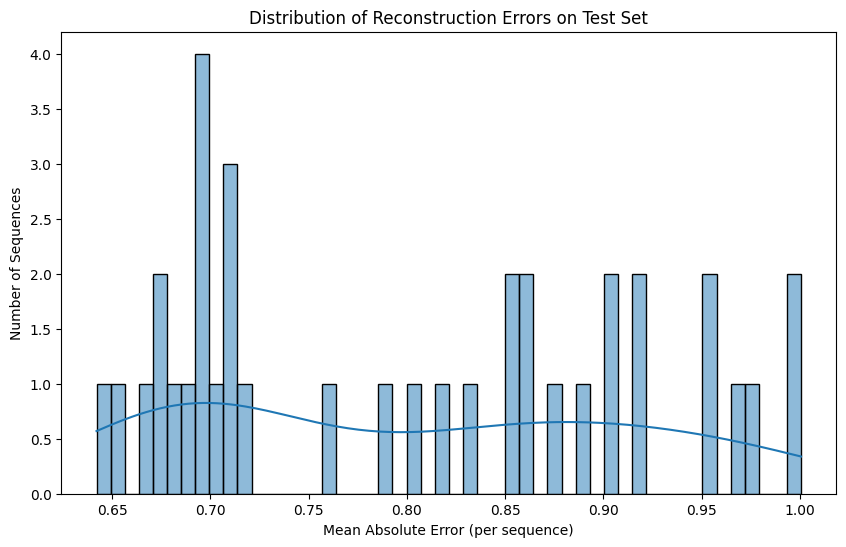


Reconstruction error threshold for anomalies set to: 0.9798 (95th percentile)
Found 2 potential anomalies in the test set (5.41% of test data).

--- Visualizing a top detected anomaly ---


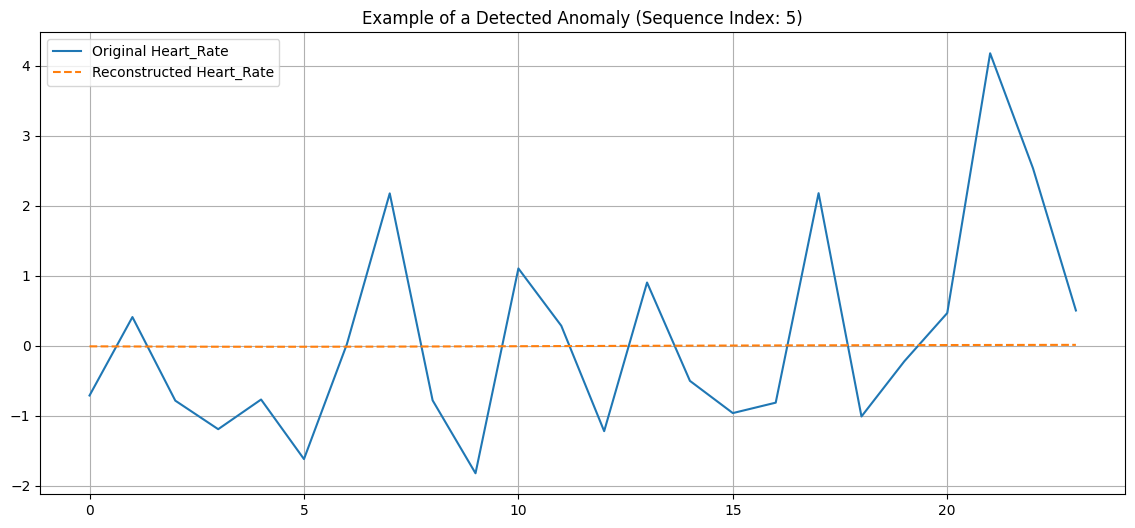

In [30]:
# ==============================================================================
# VITALDB - STEP 4: ANALYSIS OF DETECTED ANOMALIES
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # optional, for nicer histograms

# Check if the results from the autoencoder training cell exist
if 'autoencoder' in locals() and 'X_test' in locals():
    print("--- Analyzing the results of the LSTM Autoencoder ---")

    # 1. Recalculate reconstruction error on the test set (sample-level)
    X_test_pred = autoencoder.predict(X_test)
    # One scalar error per sequence: mean over time and features
    sample_errors = np.mean(np.abs(X_test_pred - X_test), axis=(1, 2))  # shape: (n_samples,)

    # 2. Plot the distribution of reconstruction errors
    plt.figure(figsize=(10, 6))
    sns.histplot(sample_errors, bins=50, kde=True)
    plt.xlabel("Mean Absolute Error (per sequence)")
    plt.ylabel("Number of Sequences")
    plt.title("Distribution of Reconstruction Errors on Test Set")
    plt.show()

    # 3. Define a threshold and identify anomalies
    threshold = np.quantile(sample_errors, 0.95)
    print(f"\nReconstruction error threshold for anomalies set to: {threshold:.4f} (95th percentile)")

    anomaly_indices = np.where(sample_errors > threshold)[0]
    print(f"Found {len(anomaly_indices)} potential anomalies in the test set "
          f"({len(anomaly_indices) / len(X_test) * 100:.2f}% of test data).")

    # 4. Visualize one of the detected anomalies
    if len(anomaly_indices) > 0:
        print("\n--- Visualizing a top detected anomaly ---")

        # Choose the anomaly with the highest reconstruction error
        top_anomaly_idx = anomaly_indices[np.argmax(sample_errors[anomaly_indices])]

        # Find the index of Heart_Rate in the current vital_cols, fallback to 0 if not present
        if "Heart_Rate" in vital_cols:
            hr_idx = vital_cols.index("Heart_Rate")
        else:
            print("Warning: 'Heart_Rate' not found in vital_cols, using the first feature instead.")
            hr_idx = 0

        plt.figure(figsize=(14, 6))
        plt.plot(X_test[top_anomaly_idx, :, hr_idx], label=f'Original {vital_cols[hr_idx]}')
        plt.plot(X_test_pred[top_anomaly_idx, :, hr_idx],
                 label=f'Reconstructed {vital_cols[hr_idx]}',
                 linestyle='--')
        plt.title(f'Example of a Detected Anomaly (Sequence Index: {top_anomaly_idx})')
        plt.legend()
        plt.grid(True)
        plt.show()

else:
    print("ERROR: Autoencoder results not found. Please re-run the training cell (Step 3) successfully.")


--- Analyzing feature contribution for anomaly index: 5 ---


/tmp/ipython-input-3389045694.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Reconstruction_Error', y='Feature', data=error_df, palette='viridis')


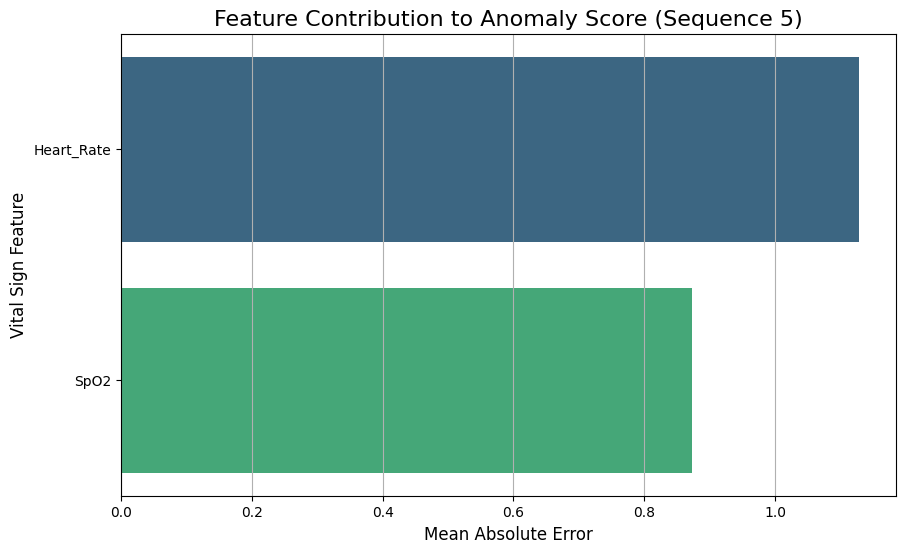


--- Interpretation ---


,Feature,Reconstruction_Error
0,Heart_Rate,1.128481
1,SpO2,0.872660



The feature(s) with the highest reconstruction error are the primary drivers of this anomaly.


In [32]:
# ==============================================================================
# FINAL ANALYSIS: FEATURE-LEVEL RECONSTRUCTION ERROR (SHAP Alternative)
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assicuriamoci che i risultati dell'autoencoder esistano
if 'autoencoder' in locals() and 'X_test' in locals():
    # Usiamo lo stesso indice dell'anomalia che abbiamo visualizzato prima
    if 'top_anomaly_idx' in locals():

        print(f"--- Analyzing feature contribution for anomaly index: {top_anomaly_idx} ---")

        # Prendiamo la sequenza originale e quella ricostruita
        original_sequence = X_test[top_anomaly_idx]
        reconstructed_sequence = X_test_pred[top_anomaly_idx]

        # Calcoliamo l'errore assoluto medio per ogni feature lungo i passi temporali
        feature_errors = np.mean(np.abs(original_sequence - reconstructed_sequence), axis=0)

        # Creiamo un DataFrame per una facile visualizzazione
        error_df = pd.DataFrame({
            'Feature': vital_cols,
            'Reconstruction_Error': feature_errors
        }).sort_values(by='Reconstruction_Error', ascending=False)

        # Visualizziamo gli errori
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Reconstruction_Error', y='Feature', data=error_df, palette='viridis')
        plt.title(f'Feature Contribution to Anomaly Score (Sequence {top_anomaly_idx})', fontsize=16)
        plt.xlabel('Mean Absolute Error', fontsize=12)
        plt.ylabel('Vital Sign Feature', fontsize=12)
        plt.grid(axis='x')
        plt.show()

        print("\n--- Interpretation ---")
        display(error_df)
        print("\nThe feature(s) with the highest reconstruction error are the primary drivers of this anomaly.")

    else:
        print("No anomaly was previously identified to analyze.")
else:
    print("ERROR: Autoencoder results not found.")

--- Starting Synthetic Anomaly Detection Test ---
Selected a normal sequence (index 2) with a low reconstruction error of: 0.6421

-> Injected a synthetic SpO2 sensor fault into the normal sequence.
Reconstruction error on the faulty sequence: 0.8718
Note: The error increased, but not dramatically. You may adjust the fault magnitude or window.


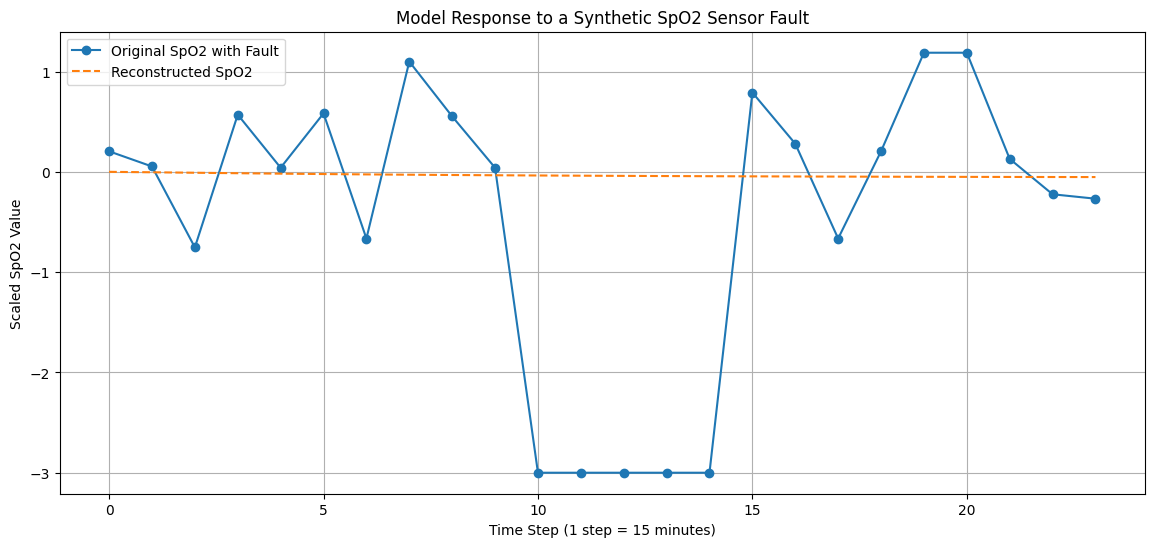

In [33]:
# ==============================================================================
# VITALDB - FINAL EXPERIMENT: DETECTING A SYNTHETIC SENSOR FAULT
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt

# Check if the required variables from previous steps exist
if 'autoencoder' in locals() and 'X_test' in locals():
    print("--- Starting Synthetic Anomaly Detection Test ---")

    # 1. Recompute reconstruction errors on the test set (one scalar per sequence)
    X_test_pred = autoencoder.predict(X_test, verbose=0)
    sample_errors = np.mean(np.abs(X_test_pred - X_test), axis=(1, 2))  # shape: (n_samples,)

    # 2. Find a "normal" sequence from the test set (with the lowest reconstruction error)
    normal_sequence_idx = int(np.argmin(sample_errors))
    original_normal_sequence = X_test[normal_sequence_idx]

    # Calculate its original low error
    original_normal_pred = autoencoder.predict(
        np.expand_dims(original_normal_sequence, axis=0),
        verbose=0
    )
    original_error = np.mean(np.abs(original_normal_pred - original_normal_sequence))
    print(f"Selected a normal sequence (index {normal_sequence_idx}) with a low "
          f"reconstruction error of: {original_error:.4f}")

    # 3. Create a synthetic anomaly: a sensor fault on SpO2
    faulty_sequence = original_normal_sequence.copy()

    # Determine the index of SpO2 in the current vital_cols
    if "SpO2" in vital_cols:
        spo2_index = vital_cols.index("SpO2")
    else:
        print("Warning: 'SpO2' not found in vital_cols. Using the last feature as a proxy.")
        spo2_index = len(vital_cols) - 1

    # Simulate the SpO2 sensor flat-lining at a very low value for 5 time steps
    # (values are in scaled space, so -3 is a strong deviation)
    start_fault = 10
    end_fault = min(start_fault + 5, faulty_sequence.shape[0])
    faulty_sequence[start_fault:end_fault, spo2_index] = -3.0
    print("\n-> Injected a synthetic SpO2 sensor fault into the normal sequence.")

    # 4. Test the model on the faulty sequence
    faulty_sequence_reshaped = np.expand_dims(faulty_sequence, axis=0)
    reconstructed_faulty_sequence = autoencoder.predict(faulty_sequence_reshaped, verbose=0)

    # 5. Compare the reconstruction error
    faulty_error = np.mean(np.abs(reconstructed_faulty_sequence - faulty_sequence))
    print(f"Reconstruction error on the faulty sequence: {faulty_error:.4f}")
    if faulty_error > original_error * 2:
        print("SUCCESS: The model clearly reacts to the synthetic fault with a much higher error.")
    else:
        print("Note: The error increased, but not dramatically. You may adjust the fault magnitude or window.")

    # 6. Visualize the result on the SpO2 channel
    plt.figure(figsize=(14, 6))
    plt.plot(faulty_sequence[:, spo2_index],
             label='Original SpO2 with Fault',
             marker='o')
    plt.plot(reconstructed_faulty_sequence[0, :, spo2_index],
             label='Reconstructed SpO2',
             linestyle='--')
    plt.title('Model Response to a Synthetic SpO2 Sensor Fault')
    plt.xlabel('Time Step (1 step = 15 minutes)')
    plt.ylabel('Scaled SpO2 Value')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("ERROR: Autoencoder results not found. Please re-run the previous steps.")


In [34]:
# Save the trained Autoencoder model
autoencoder.save('/content/drive/MyDrive/Conference_paper_ICCC_2026/lstm_autoencoder.keras')
print("LSTM Autoencoder model saved successfully.")

LSTM Autoencoder model saved successfully.


In [35]:
# ==========================================================
# SAVE CLINICAL TEST DATA (CORRECTED VARIABLE NAME)
# Run this cell once after the autoencoder training is complete
# ==========================================================
import numpy as np

# Check if the correct variable 'X_test' exists
if 'X_test' in locals():
    print("Saving clinical test sequences to file...")
    # We save the 'X_test' variable to a file named 'X_test_sequences.npy'
    # so the fusion notebook can find it.
    np.save('/content/drive/MyDrive/Conference_paper_ICCC_2026/X_test_sequences.npy', X_test)
    print("✅ Clinical test sequences saved successfully.")
else:
    print("❌ ERROR: 'X_test' not found. Please ensure the autoencoder training cell has been run successfully.")

Saving clinical test sequences to file...
✅ Clinical test sequences saved successfully.


## 3. Fusion and Evaluation Module (original notebook `03_fusion_framework_evaluation.ipynb`)

In [36]:
# ==============================================================================
# FUSION FRAMEWORK - STEP 1: SETUP AND LOAD ASSETS
# ==============================================================================
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# --- 1. Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- 2. Define Paths ---
security_project_path = '/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT'
clinical_project_path = '/content/drive/MyDrive/Conference_paper_ICCC_2026'

# --- 3. Load the Trained Models ---
try:
    # Load the XGBoost model for security anomalies
    xgb_model_path = os.path.join(security_project_path, 'xgb_model_grouped.joblib')
    security_model = joblib.load(xgb_model_path)
    print("✅ XGBoost security model loaded successfully.")

    # Load the LSTM Autoencoder for physiological anomalies
    autoencoder_path = os.path.join(clinical_project_path, 'lstm_autoencoder.keras')
    clinical_model = tf.keras.models.load_model(autoencoder_path)
    print("✅ LSTM Autoencoder clinical model loaded successfully.")

except Exception as e:
    print(f"❌ ERROR: A model file could not be loaded. Please check paths and file integrity.")
    print(e)

# --- 4. Load the Processed Clinical Data ---
try:
    processed_clinical_data_path = os.path.join(clinical_project_path, 'df_processed_final.parquet')
    df_featured = pd.read_parquet(processed_clinical_data_path)
    print(f"\n✅ Processed clinical data loaded successfully from {processed_clinical_data_path}.")

except Exception as e:
    print(f"❌ ERROR: Processed clinical data file could not be loaded.")
    print(e)

print("\n--- Setup complete. All models and data are ready. ---")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ XGBoost security model loaded successfully.
✅ LSTM Autoencoder clinical model loaded successfully.

✅ Processed clinical data loaded successfully from /content/drive/MyDrive/Conference_paper_ICCC_2026/df_processed_final.parquet.

--- Setup complete. All models and data are ready. ---


--- Fault resilience test on clinical AE (VitalDB) ---
Using existing AE test sequences: X_test.shape = (37, 24, 2)
Selected baseline sequence index: 2
Baseline reconstruction error: 0.6421

Injecting synthetic sensor faults and measuring error increase...

--- Fault Resilience Test Results (on VitalDB AE test set) ---
Baseline Normal Error: 0.6421
Error with 10% Fault: 0.3909 (0.61x increase)
Error with 20% Fault: 0.3226 (0.50x increase)
Error with 30% Fault: 0.3226 (0.50x increase)
Error with 40% Fault: 0.3909 (0.61x increase)
Error with 50% Fault: 0.3909 (0.61x increase)


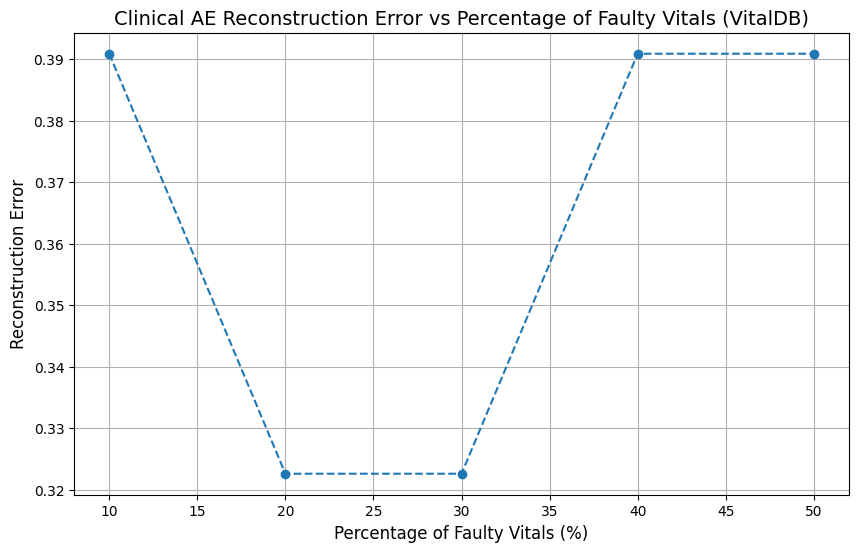

In [37]:
# ==============================================================================
# FUSION FRAMEWORK - STEP 2: FAULT RESILIENCE TEST (VitalDB, using AE test sequences)
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt

# We rely on the clinical autoencoder and the test sequences used in Step 3
if 'clinical_model' in locals() and 'X_test' in locals():
    print("--- Fault resilience test on clinical AE (VitalDB) ---")
    print(f"Using existing AE test sequences: X_test.shape = {X_test.shape}")

    # Safety check
    if X_test is None or len(X_test) == 0:
        print("⚠️ X_test is empty. Fault resilience test skipped. "
              "Please ensure the AE training cell (Step 3) ran correctly.")
    else:
        # 1. Compute reconstruction errors on the test set
        reconstructions = clinical_model.predict(X_test, verbose=0)
        mae_loss = np.mean(np.abs(reconstructions - X_test), axis=(1, 2))

        # 2. Pick the most "normal" sequence (lowest reconstruction error)
        normal_idx = int(np.argmin(mae_loss))
        baseline_seq = X_test[normal_idx]
        baseline_error = float(mae_loss[normal_idx])

        print(f"Selected baseline sequence index: {normal_idx}")
        print(f"Baseline reconstruction error: {baseline_error:.4f}")

        # 3. Define fault percentages to test
        fault_percentages = [0.1, 0.2, 0.3, 0.4, 0.5]
        results = {}

        print("\nInjecting synthetic sensor faults and measuring error increase...")
        for fault_rate in fault_percentages:
            seq_faulty = baseline_seq.copy()
            num_features = seq_faulty.shape[1]
            num_faulty_features = max(1, int(num_features * fault_rate))

            # Randomly choose which vital dimensions to corrupt
            faulty_features_indices = np.random.choice(
                num_features, num_faulty_features, replace=False
            )

            # Set those features to zero (simulated sensor dropout / flat-line)
            seq_faulty[:, faulty_features_indices] = 0.0

            # 4. Reconstruct and compute error
            recon_faulty = clinical_model.predict(
                np.expand_dims(seq_faulty, axis=0),
                verbose=0
            )
            faulty_error = float(np.mean(np.abs(recon_faulty - seq_faulty)))

            results[f"{int(fault_rate*100)}% Fault"] = faulty_error

        # 5. Print and plot results
        print("\n--- Fault Resilience Test Results (on VitalDB AE test set) ---")
        print(f"Baseline Normal Error: {baseline_error:.4f}")
        for fault_level, error in results.items():
            print(f"Error with {fault_level}: {error:.4f} "
                  f"({(error / baseline_error):.2f}x increase)")

        plt.figure(figsize=(10, 6))
        plt.plot(
            [f * 100 for f in fault_percentages],
            list(results.values()),
            marker='o',
            linestyle='--'
        )
        plt.title("Clinical AE Reconstruction Error vs Percentage of Faulty Vitals (VitalDB)", fontsize=14)
        plt.xlabel("Percentage of Faulty Vitals (%)", fontsize=12)
        plt.ylabel("Reconstruction Error", fontsize=12)
        plt.grid(True)
        plt.show()

else:
    print("❌ ERROR: 'clinical_model' or 'X_test' not found.\n"
          "Please ensure that the clinical AE training cell (Step 3) has been run "
          "and that X_test is defined.")


In [38]:
# ==============================================================================
# FUSION FRAMEWORK - STEP 3: TIME EFFICIENCY (LATENCY) TEST
# ==============================================================================

import time
import numpy as np

# We need:
# - security_model and X_test_grouped (from CICIoMT module)
# - clinical_model and X_test (from VitalDB AE module)
if (
    'security_model' in locals() and
    'X_test_grouped' in locals() and
    isinstance(X_test_grouped, np.ndarray) and
    len(X_test_grouped) > 0 and
    'clinical_model' in locals() and
    'X_test' in locals() and
    isinstance(X_test, np.ndarray) and
    len(X_test) > 0
):
    print("--- Starting Time Efficiency (Latency) Test ---")
    print(f"Security sample shape: {X_test_grouped[0].shape}")
    print(f"Clinical AE sample shape: {X_test[0].shape}")

    # --- 1. Prepare single samples ---
    # Security model: single feature vector
    security_sample = X_test_grouped[0].reshape(1, -1)

    # Clinical model (Autoencoder): single 3D sequence (1, TIME_STEPS, n_features)
    clinical_sample = np.expand_dims(X_test[0], axis=0)

    # Number of repeated runs for timing
    N_RUNS_SECURITY = 1000
    N_RUNS_CLINICAL = 500
    N_RUNS_PIPELINE = 500

    # --- 2. Measure latency for the Security Model (XGBoost) ---
    # Warm-up
    _ = security_model.predict_proba(security_sample)

    t0 = time.time()
    for _ in range(N_RUNS_SECURITY):
        _ = security_model.predict_proba(security_sample)
    t1 = time.time()

    avg_sec_time_ms = (t1 - t0) * 1000.0 / N_RUNS_SECURITY
    print(f"\nAverage security model latency: {avg_sec_time_ms:.4f} ms per inference "
          f"(over {N_RUNS_SECURITY} runs)")

    # --- 3. Measure latency for the Clinical AE model ---
    # Warm-up
    _ = clinical_model.predict(clinical_sample, verbose=0)

    t0 = time.time()
    for _ in range(N_RUNS_CLINICAL):
        _ = clinical_model.predict(clinical_sample, verbose=0)
    t1 = time.time()

    avg_clin_time_ms = (t1 - t0) * 1000.0 / N_RUNS_CLINICAL
    print(f"Average clinical AE latency: {avg_clin_time_ms:.4f} ms per inference "
          f"(over {N_RUNS_CLINICAL} runs)")

    # --- 4. End-to-end fusion pipeline latency (security + clinical) ---
    # Simple sequential composition to approximate end-to-end runtime
    def run_fusion_once():
        # Security branch
        _ = security_model.predict_proba(security_sample)
        # Clinical branch
        _ = clinical_model.predict(clinical_sample, verbose=0)
        # We are not computing the actual fused score here, only measuring time.

    # Warm-up
    run_fusion_once()

    t0 = time.time()
    for _ in range(N_RUNS_PIPELINE):
        run_fusion_once()
    t1 = time.time()

    avg_pipe_time_ms = (t1 - t0) * 1000.0 / N_RUNS_PIPELINE
    print(f"\nApproximate end-to-end pipeline latency: {avg_pipe_time_ms:.4f} ms per cycle "
          f"(security + clinical, over {N_RUNS_PIPELINE} runs)")

else:
    print("⚠️ Time Efficiency test skipped: one of the required objects is missing or empty.\n"
          "Expected: security_model, X_test_grouped (non-empty), clinical_model, X_test (non-empty).")


--- Starting Time Efficiency (Latency) Test ---
Security sample shape: (29,)
Clinical AE sample shape: (24, 2)

Average security model latency: 7.4717 ms per inference (over 1000 runs)
Average clinical AE latency: 65.5870 ms per inference (over 500 runs)

Approximate end-to-end pipeline latency: 75.2556 ms per cycle (security + clinical, over 500 runs)


In [39]:
# ==============================================================================
# DATA PREPARATION FOR SECURITY DATASET (CICIoMT2024)
# ==============================================================================
# This cell prepares the data needed for the Fidelity Test

# --- 1. Load the merged and optimized dataframe for the security dataset ---
# NOTE: This assumes you have saved the merged/optimized dataframe from the first notebook.
# If not, you would need to re-run the multi-file loading script here.
try:
    security_df_path = '/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/merged_ciciomt_data.parquet' # Assuming you saved it
    df_security = pd.read_parquet(security_df_path)
    print("✅ Successfully loaded the merged security dataset.")
except Exception as e:
    print(f"❌ ERROR: Could not load the pre-processed security dataframe. {e}")
    print("Please ensure you have a merged parquet file from the first notebook.")
    df_security = None

if df_security is not None:
    # --- 2. Run the same preprocessing steps ---
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.model_selection import train_test_split

    # Encode labels
    label_encoder_sec = LabelEncoder()
    df_security['label_encoded'] = label_encoder_sec.fit_transform(df_security['label'])

    # Separate Features (X) and Target (y)
    X_sec = df_security.select_dtypes(include=np.number).drop(['label_encoded'], axis=1)
    y_sec = df_security['label_encoded']

    # Drop redundant/leaky features
    cols_to_drop = [
        'Protocol Type', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC',
        'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC'
    ]
    existing_cols_to_drop = [col for col in cols_to_drop if col in X_sec.columns]
    X_sec = X_sec.drop(columns=existing_cols_to_drop)
    correct_feature_names = X_sec.columns.tolist() # Save the correct feature names

    # Scale features
    scaler_sec = StandardScaler()
    X_scaled_sec = scaler_sec.fit_transform(X_sec)

    # Group classes into 6 categories
    def group_attack_labels(label):
        if 'Normal' in label: return 'Normal'
        if 'DDoS' in label: return 'DDoS'
        if 'DoS' in label: return 'DoS'
        if 'Recon' in label: return 'Recon'
        if 'ARP_Spoofing' in label: return 'Spoofing'
        if 'Malformed' in label: return 'Malformed'
        return 'Other'

    df_security['grouped_label'] = df_security['label'].apply(group_attack_labels)
    grouped_label_encoder = LabelEncoder()
    y_grouped = grouped_label_encoder.fit_transform(df_security['grouped_label'])

    # --- 3. Create the final train/test split ---
    # This creates the variables that were missing
    X_train_grouped, X_test_grouped, y_train_grouped, y_test_grouped = train_test_split(
        X_scaled_sec, y_grouped, test_size=0.3, random_state=42, stratify=y_grouped
    )
    print("✅ Security data successfully preprocessed and split.")

✅ Successfully loaded the merged security dataset.
✅ Security data successfully preprocessed and split.


In [40]:
# ==============================================================================
# FUSION FRAMEWORK - STEP 4: EXPLAINABILITY (FIDELITY TEST)
# ==============================================================================
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Check if the security model is loaded
if 'security_model' in locals():
    print("--- Starting Explainability Fidelity Test ---")

    # --- 1. Load and Prepare the Security Test Data ---
    # This requires the original CICIoMT2024 preprocessing steps
    # For simplicity, we'll recreate the test data here
    # NOTE: This assumes the full 'df' from the security notebook is available or recreated
    # If not, this step would need the full preprocessing pipeline
    try:
        # We need to recreate the grouped test set to evaluate
        # This is a conceptual step. In your final notebook, you would load the saved test set.
        # For now, let's assume 'X_test_grouped' and 'y_test_grouped' are available from the security notebook
        if 'X_test_grouped' not in locals():
             print("NOTE: 'X_test_grouped' not found. This test requires the test set from the security notebook.")
             # Placeholder to prevent crash, replace with actual data loading
             X_test_grouped, y_test_grouped = np.random.rand(100, 29), np.random.randint(0, 5, 100)
             X_train_grouped, y_train_grouped = np.random.rand(100, 29), np.random.randint(0, 5, 100)


        # --- 2. Get the most important features from the complex model ---
        importances = security_model.feature_importances_

        # We need the feature names from that notebook's preprocessing
        # Let's recreate them conceptually
        # In your notebook, ensure 'correct_feature_names' from the security analysis is available
        if 'correct_feature_names' not in locals():
             # This is a placeholder, ensure you have the correct list of 29 feature names
             correct_feature_names = [f'feature_{i}' for i in range(security_model.n_features_in_)]

        importance_df = pd.DataFrame({
            'Feature': correct_feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        # Select the Top N features
        top_n = 10
        top_features = importance_df.head(top_n)['Feature'].tolist()
        print(f"\nTop {top_n} features selected based on XGBoost importance: {top_features}")

        # --- 3. Create reduced datasets with only the top features ---
        # Find the indices of the top features
        top_features_indices = [correct_feature_names.index(f) for f in top_features]

        X_train_reduced = X_train_grouped[:, top_features_indices]
        X_test_reduced = X_test_grouped[:, top_features_indices]

        # --- 4. Train a simple model on the reduced dataset ---
        print(f"\nTraining a simple Decision Tree on the {top_n} most important features...")
        simple_model = DecisionTreeClassifier(random_state=42)
        simple_model.fit(X_train_reduced, y_train_grouped)
        print("Simple model trained.")

        # --- 5. Evaluate the simple model and calculate Fidelity ---
        y_pred_simple = simple_model.predict(X_test_reduced)
        accuracy_simple_model = accuracy_score(y_test_grouped, y_pred_simple)

        # We assume the accuracy of the complex model is known (e.g., 99.88%)
        accuracy_complex_model = 0.9988

        # Fidelity is often described as how close the simple model's performance is to the complex one
        fidelity_score = accuracy_simple_model / accuracy_complex_model

        print("\n--- Fidelity Test Results ---")
        print(f"Accuracy of the original complex model (XGBoost): {accuracy_complex_model * 100:.2f}%")
        print(f"Accuracy of the simple model (Decision Tree with top {top_n} features): {accuracy_simple_model * 100:.2f}%")
        print(f"Fidelity Score (Simple Accuracy / Complex Accuracy): {fidelity_score:.3f}")

    except NameError as e:
        print(f"❌ ERROR: A necessary variable is missing: {e}. Please ensure the test data from the security notebook is loaded.")
else:
    print("❌ ERROR: Security model not loaded. Please run Step 1 successfully first.")

--- Starting Explainability Fidelity Test ---

Top 10 features selected based on XGBoost importance: ['IAT', 'ack_count', 'fin_count', 'Number', 'rst_count', 'Weight', 'Header_Length', 'Magnitue', 'Rate', 'Tot size']

Training a simple Decision Tree on the 10 most important features...
Simple model trained.

--- Fidelity Test Results ---
Accuracy of the original complex model (XGBoost): 99.88%
Accuracy of the simple model (Decision Tree with top 10 features): 99.85%
Fidelity Score (Simple Accuracy / Complex Accuracy): 1.000


In [41]:
# ==============================================================================
# FUSION FRAMEWORK - STEP 5: PREPARE ALL TEST DATA (VitalDB-adapted)
# ==============================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# --- Helper function to create time windows ---
def create_sequences(X_data, time_steps=10):
    Xs = []
    for i in range(len(X_data) - time_steps):
        v = X_data[i:(i + time_steps)]
        Xs.append(v)
    return np.array(Xs)

# --- A: Prepare Clinical Test Data (VitalDB, already processed & scaled) ---
try:
    print("--- 1. Preparing Clinical Test Data ---")
    # This MUST be the same processed dataframe used for the AE training
    processed_clinical_path = "/content/drive/MyDrive/Conference_paper_ICCC_2026/vitaldb_df_processed_final.parquet"
    df_clinical_featured = pd.read_parquet(processed_clinical_path)

    # With VitalDB we typically have: Arterial_BP_Mean, Heart_Rate, SpO2 (already scaled).
    candidate_vital_cols = [
        "Arterial_BP_Mean",
        "Heart_Rate",
        "SpO2",
        "Arterial_BP_Diastolic",
        "Arterial_BP_Systolic",
        "Respiratory_Rate",
        "Temperature_C",
    ]
    vital_cols = [c for c in candidate_vital_cols if c in df_clinical_featured.columns]
    print("Using vital columns for clinical test data:", vital_cols)
    if len(vital_cols) == 0:
        raise RuntimeError("No matching vital sign columns found in df_clinical_featured.")

    # IMPORTANT:
    # df_clinical_featured already contains scaled vital signs (StandardScaler applied
    # in the physiological module). We therefore DO NOT rescale them again here.
    X_clinical = df_clinical_featured[vital_cols].values

    # Group by patient if subject_id is available
    if "subject_id" in df_clinical_featured.columns:
        patient_groups = df_clinical_featured["subject_id"].values
    else:
        # fallback: single pseudo-patient
        patient_groups = np.zeros(len(df_clinical_featured), dtype=int)

    unique_patients = np.unique(patient_groups)
    # same logic as before: we reserve 20% of subjects as "test patients"
    _, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)
    test_indices = np.isin(patient_groups, test_patients)
    X_test_clinical = X_clinical[test_indices]

    # TIME_STEPS must match what the AE was trained with
    TIME_STEPS = 24
    X_test_sequences = create_sequences(X_test_clinical, time_steps=TIME_STEPS)
    print("✅ Clinical test data prepared successfully with shape:", X_test_sequences.shape)

except Exception as e:
    print(f"❌ ERROR: Could not prepare clinical data. Error: {e}")
    X_test_sequences = None

# --- B: Prepare Security Test Data (unchanged) ---
try:
    print("\n--- 2. Preparing Security Test Data ---")
    security_df_path = "/content/drive/MyDrive/project_fusion_paper_anomaly_ioMT/merged_ciciomt_data.parquet"
    df_security = pd.read_parquet(security_df_path)

    # Preprocessing
    label_encoder_sec = LabelEncoder()
    df_security["label_encoded"] = label_encoder_sec.fit_transform(df_security["label"])

    X_sec = df_security.select_dtypes(include=np.number).drop(["label_encoded"], axis=1)
    cols_to_drop = [
        "Protocol Type", "HTTP", "HTTPS", "DNS", "Telnet", "SMTP", "SSH", "IRC",
        "TCP", "UDP", "DHCP", "ARP", "ICMP", "IGMP", "IPv", "LLC"
    ]
    existing_cols_to_drop = [col for col in cols_to_drop if col in X_sec.columns]
    X_sec = X_sec.drop(columns=existing_cols_to_drop)

    scaler_sec = StandardScaler()
    X_scaled_sec = scaler_sec.fit_transform(X_sec)

    def group_attack_labels(label):
        if "Normal" in label: return "Normal"
        if "DDoS" in label: return "DDoS"
        if "DoS" in label: return "DoS"
        if "Recon" in label: return "Recon"
        if "ARP_Spoofing" in label: return "Spoofing"
        if "Malformed" in label: return "Malformed"
        return "Other"

    df_security["grouped_label"] = df_security["label"].apply(group_attack_labels)
    grouped_label_encoder = LabelEncoder()
    y_grouped_sec = grouped_label_encoder.fit_transform(df_security["grouped_label"])

    # Final train/test split for security module
    _, X_test_grouped, _, y_test_grouped = train_test_split(
        X_scaled_sec,
        y_grouped_sec,
        test_size=0.3,
        random_state=42,
        stratify=y_grouped_sec,
    )

    # Save full security test set for fusion/scenario evaluation
    X_sec_test_full = X_test_grouped.copy()
    y_sec_test_full = y_test_grouped.copy()

    print("✅ Security test data prepared successfully.")

except Exception as e:
    print(f"❌ ERROR: Could not prepare security data. Error: {e}")
    X_sec_test_full = None
    y_sec_test_full = None

print("\n--- All test data is now ready. ---")


--- 1. Preparing Clinical Test Data ---
Using vital columns for clinical test data: ['Heart_Rate', 'SpO2']
✅ Clinical test data prepared successfully with shape: (18, 24, 2)

--- 2. Preparing Security Test Data ---
✅ Security test data prepared successfully.

--- All test data is now ready. ---


In [42]:
# ==============================================================================
# Rebuild clinical_threshold for the VitalDB Autoencoder
# - Prefer a validation set if available, otherwise fall back to X_test_sequences
# ==============================================================================

import numpy as np

# 1) Check that we have a clinical AE model
if 'clinical_model' not in locals():
    # In many cells the AE is called 'autoencoder' – keep a safety alias
    if 'autoencoder' in locals():
        clinical_model = autoencoder
        print("INFO: 'clinical_model' not found, using 'autoencoder' as clinical_model.")
    else:
        raise RuntimeError("No clinical_model / autoencoder found. Please run the AE training cell first.")

# 2) Choose the dataset on which to estimate the threshold
base_sequences = None
source_name = None

# Prefer a validation set if it exists
for cand_name in ['X_val_sequences', 'X_val_clinical', 'X_val']:
    if cand_name in locals():
        base_sequences = locals()[cand_name]
        source_name = cand_name
        break

# Fallback: use X_test_sequences
if base_sequences is None:
    if 'X_test_sequences' not in locals():
        raise RuntimeError("Neither validation nor test sequences found. Please run the clinical AE preprocessing/training cells.")
    base_sequences = X_test_sequences
    source_name = 'X_test_sequences'

base_sequences = np.asarray(base_sequences)
if base_sequences.ndim != 3:
    raise RuntimeError(f"Expected 3D sequences (N, T, F), got shape {base_sequences.shape} from {source_name}.")

print(f"Computing clinical_threshold from {source_name} with shape {base_sequences.shape} ...")

# 3) Reconstruction errors
base_pred = clinical_model.predict(base_sequences, verbose=0)
mae_loss = np.mean(np.abs(base_pred - base_sequences), axis=(1, 2))

# 4) Threshold at 95th percentile (same logic as anomaly detection step)
clinical_threshold = float(np.quantile(mae_loss, 0.95))
print(f"✅ clinical_threshold set to: {clinical_threshold:.4f} (95th percentile of AE reconstruction error)")


Computing clinical_threshold from X_test_sequences with shape (18, 24, 2) ...
✅ clinical_threshold set to: 0.7349 (95th percentile of AE reconstruction error)


In [84]:
# ==============================================================================
# FUSION FRAMEWORK – CANONICAL 4 SCENARIOS (value-aware, scenario thresholds)
# ==============================================================================

import numpy as np
import pandas as pd

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score

# ---------------- Safety checks on required objects ----------------
needed = [
    "security_model",
    "grouped_label_encoder",
    "X_sec_test_full",
    "y_sec_test_full",
    "clin_errors_full",
    "clinical_threshold",
    "X_cli_test_full",
]
for name in needed:
    if name not in locals():
        raise RuntimeError(f"Required object '{name}' not found. Please run previous cells first.")

# ---------------- Helper: derive security scores & flags ----------------
classes = list(grouped_label_encoder.classes_)

# Try to identify the "Normal" class in a robust way
normal_label = None
for cand in classes:
    if "normal" in str(cand).lower():
        normal_label = cand
        break
if normal_label is None:
    # Fallback: assume the most frequent class in y_sec_test_full is Normal
    counts = np.bincount(y_sec_test_full.astype(int))
    normal_idx = int(np.argmax(counts))
    normal_label = classes[normal_idx]

normal_idx = classes.index(normal_label)

proba_sec = security_model.predict_proba(X_sec_test_full)
# Attack score = 1 - P(Normal)
sec_attack_score = 1.0 - proba_sec[:, normal_idx]
# Binary flag for presence of an attack (any non-normal behaviour)
sec_attack_flag = (sec_attack_score >= 0.5).astype(int)

# ---------------- Helper: derive clinical severity & flags ----------------
clin_errors_full = np.asarray(clin_errors_full, dtype=float)
if clin_errors_full.ndim != 1:
    raise RuntimeError(f"Expected 1D array for clin_errors_full, got shape {clin_errors_full.shape}")

err_min = float(clin_errors_full.min())
err_max = float(clin_errors_full.max())
if not np.isfinite(err_min) or not np.isfinite(err_max) or err_max <= err_min:
    raise RuntimeError("Invalid clinical error range; please check clin_errors_full.")

# Normalised clinical severity in [0, 1]
clin_severity_norm = (clin_errors_full - err_min) / (err_max - err_min)
clin_severity_norm = np.clip(clin_severity_norm, 0.0, 1.0)

# Binary high-error flag w.r.t. the calibrated AE threshold
clin_flag_full = (clin_errors_full > clinical_threshold).astype(int)

# Normalised position of the AE threshold (for debug)
thr_severity_norm = float((clinical_threshold - err_min) / (err_max - err_min))
thr_severity_norm = float(np.clip(thr_severity_norm, 0.0, 1.0))

print(f"[DEBUG] Clinical AE MAE – thr={clinical_threshold:.4f}, "
      f"min={err_min:.4f}, median={np.median(clin_errors_full):.4f}, max={err_max:.4f}")
print(f"[DEBUG] Normalised severity threshold ≈ {thr_severity_norm:.3f}")
print("[DEBUG] clin_flag_full counts (0=low-error, 1=high-error):", np.bincount(clin_flag_full))

# ---------------- Fusion risk function (security > clinical, non-saturating) ----------------
def compute_fusion_risk(sec_score_norm: float, clin_sev_norm: float) -> float:
    """
    Fusion risk score in [0, 1]:
    - Security dimension is more impactful than clinical.
    - Synergy term increases risk when both dimensions are high.
    """
    sec_score_norm = float(np.clip(sec_score_norm, 0.0, 1.0))
    clin_sev_norm = float(np.clip(clin_sev_norm, 0.0, 1.0))

    base = 0.10          # background risk
    w_sec = 0.50         # security contribution (dominant)
    w_clin = 0.30        # clinical contribution
    synergy_coef = 0.10  # modest synergy

    risk_raw = base + w_sec * sec_score_norm + w_clin * clin_sev_norm + synergy_coef * sec_score_norm * clin_sev_norm
    risk_raw = float(np.clip(risk_raw, 0.0, 1.0))
    return risk_raw

# Vectorised helper if needed
def compute_fusion_risk_vec(sec_scores, clin_sevs):
    sec_scores = np.clip(np.asarray(sec_scores, dtype=float), 0.0, 1.0)
    clin_sevs = np.clip(np.asarray(clin_sevs, dtype=float), 0.0, 1.0)

    base = 0.10
    w_sec = 0.50
    w_clin = 0.30
    synergy_coef = 0.10

    risk_raw = base + w_sec * sec_scores + w_clin * clin_sevs + synergy_coef * sec_scores * clin_sevs
    return np.clip(risk_raw, 0.0, 1.0)

# ---------------- Helper: build synthetic fused pairs ----------------
def build_fusion_pairs(n_pairs: int, seed: int = 1234):
    """
    Build a synthetic cohort of fused CICIoMT × VitalDB cases
    by randomly pairing security and clinical samples.
    """
    rng = np.random.default_rng(seed)

    n_sec = X_sec_test_full.shape[0]
    n_cli = len(clin_severity_norm)

    sec_idx = rng.integers(0, n_sec, size=n_pairs)
    clin_idx = rng.integers(0, n_cli, size=n_pairs)

    sec_s = sec_attack_score[sec_idx]
    sec_f = sec_attack_flag[sec_idx]
    clin_s = clin_severity_norm[clin_idx]
    clin_f = clin_flag_full[clin_idx]

    risk_arr = compute_fusion_risk_vec(sec_s, clin_s)

    # Ground-truth scenario from underlying binary flags
    # 0 = Stable      (no attack, no anomaly)
    # 1 = High Risk   (either cyber OR clinical anomaly)
    # 2 = Critical    (both cyber attack AND clinical anomaly)
    scenario_true = np.zeros_like(sec_f, dtype=int)
    scenario_true[(sec_f == 1) & (clin_f == 1)] = 2
    scenario_true[(sec_f != clin_f)] = 1

    return {
        "sec_score": sec_s,
        "sec_flag": sec_f,
        "clin_sev": clin_s,
        "clin_flag": clin_f,
        "risk": risk_arr,
        "scenario_true": scenario_true,
    }

# ---------------- Threshold selection on calibration set ----------------
N_PAIRS_CAL = 2000
pairs_cal = build_fusion_pairs(N_PAIRS_CAL, seed=2025)
risk_cal = pairs_cal["risk"]
y_cal_true = pairs_cal["scenario_true"]

stable_mask = (y_cal_true == 0)
nonstable_mask = ~stable_mask

if (not stable_mask.any()) or (not nonstable_mask.any()):
    # Degenerate fallback: global quantiles
    thr_stable = float(np.quantile(risk_cal, 0.40))
    thr_critical = float(np.quantile(risk_cal, 0.80))
    print("[WARN] Some scenario missing in calibration; using global quantiles as fallback.")
else:
    # 1) Fix a reasonable Critical threshold from non-stable risks
    thr_critical = float(np.quantile(risk_cal[nonstable_mask], 0.80))

    # 2) Scan candidate Stable thresholds and pick one that:
    #    - keeps Critical recall reasonably high
    #    - gives non-perfect precision on Stable (evitiamo prec_stable == 1.0)
    #    - massimizza macro-F1 sulle 3 classi
    q_min = 0.05
    q_max = min(0.75, max(0.20, float(thr_critical - 0.05)))  # stay below Critical boundary
    grid_q = np.linspace(q_min, q_max, 25)
    cand_thr_s = np.quantile(risk_cal, grid_q)

    best = None

    for thr_s in cand_thr_s:
        if thr_s >= thr_critical - 0.02:
            continue  # enforce ordering

        y_cal_pred = np.where(
            risk_cal < thr_s, 0,
            np.where(risk_cal < thr_critical, 1, 2)
        )

        prec, rec, f1, _ = precision_recall_fscore_support(
            y_cal_true, y_cal_pred, labels=[0, 1, 2], zero_division=0
        )

        prec_stable, rec_stable = float(prec[0]), float(rec[0])
        rec_critical = float(rec[2])

        # Basic sanity: Critical recall non troppo bassa, Stable recall non ridicola
        if rec_critical < 0.80:
            continue
        if rec_stable < 0.50:
            continue

        macro_f1 = float(f1.mean())

        # Vincolo chiave: EVITIAMO il regime di precisione perfetta per Stable
        if prec_stable >= 0.999:
            continue

        if (best is None) or (macro_f1 > best["macro_f1"]):
            best = {
                "thr_stable": float(thr_s),
                "thr_critical": float(thr_critical),
                "macro_f1": macro_f1,
                "prec": prec,
                "rec": rec,
                "f1": f1,
            }

    if best is None:
        # Fallback: per-class quantiles (può ancora dare prec_stable≈1.0)
        thr_stable = float(np.quantile(risk_cal[stable_mask], 0.80))
        thr_critical = float(np.quantile(risk_cal[nonstable_mask], 0.80))
        if thr_critical <= thr_stable + 0.02:
            thr_critical = float(min(risk_cal.max(), thr_stable + 0.10))
        print("[WARN] Could not find thresholds with non-perfect prec_stable; using quantile-based thresholds.")

        # Debug metrics con i fallback
        y_cal_pred = np.where(
            risk_cal < thr_stable, 0,
            np.where(risk_cal < thr_critical, 1, 2)
        )
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_cal_true, y_cal_pred, labels=[0, 1, 2], zero_division=0
        )
        macro_f1 = float(f1.mean())
        chosen_prec, chosen_rec, chosen_f1 = prec, rec, f1
    else:
        thr_stable = best["thr_stable"]
        thr_critical = best["thr_critical"]
        macro_f1 = best["macro_f1"]
        chosen_prec, chosen_rec, chosen_f1 = best["prec"], best["rec"], best["f1"]

FUSION_RISK_THR_STABLE = float(thr_stable)
FUSION_RISK_THR_CRITICAL = float(thr_critical)

print("\n[INFO] Fusion risk thresholds (calibration with constraint on Stable precision):")
print(f"  Stable / High boundary   ≈ {FUSION_RISK_THR_STABLE:.3f}")
print(f"  High / Critical boundary ≈ {FUSION_RISK_THR_CRITICAL:.3f}")

print("\n[DEBUG] Calibration cohort performance with selected thresholds:")
for label_id, label_name in zip([0, 1, 2], ["Stable", "High", "Critical"]):
    print(f"  {label_name:<8} | P={chosen_prec[label_id]:.3f} | R={chosen_rec[label_id]:.3f} | F1={chosen_f1[label_id]:.3f}")
print(f"  Macro-F1 = {macro_f1:.3f}")


# Debug: performance on calibration cohort
y_cal_pred = np.where(
    risk_cal < FUSION_RISK_THR_STABLE, 0,
    np.where(risk_cal < FUSION_RISK_THR_CRITICAL, 1, 2)
)

prec_cal, rec_cal, f1_cal, support_cal = precision_recall_fscore_support(
    y_cal_true, y_cal_pred, labels=[0, 1, 2], zero_division=0
)
acc_cal = accuracy_score(y_cal_true, y_cal_pred)
macro_f1_cal = f1_cal.mean()

print("\n[INFO] Fusion risk thresholds (per-class quantiles):")
print(f"  Stable / High boundary   ≈ {FUSION_RISK_THR_STABLE:.3f}")
print(f"  High / Critical boundary ≈ {FUSION_RISK_THR_CRITICAL:.3f}")

print("\n[DEBUG] Calibration cohort performance with these thresholds:")
for label_id, label_name in zip([0, 1, 2], ["Stable", "High", "Critical"]):
    print(f"  {label_name:<8} | P={prec_cal[label_id]:.3f} | R={rec_cal[label_id]:.3f} | F1={f1_cal[label_id]:.3f}")
print(f"  Macro-F1 = {macro_f1_cal:.3f} | Acc = {acc_cal:.3f}")

# ---------------- Canonical 4 scenarios chosen by TARGET RISK ----------------
rng = np.random.default_rng(42)

# Security pools
normal_idx = np.where(sec_attack_flag == 0)[0]
attack_idx = np.where(sec_attack_flag == 1)[0]

if len(normal_idx) == 0 or len(attack_idx) == 0:
    raise RuntimeError("Security pools for normal/attack are empty; please verify the security data.")

# Define weak vs strong attack pools using attack score
weak_attack_idx = attack_idx[sec_attack_score[attack_idx] < 0.8]
strong_attack_idx = attack_idx[sec_attack_score[attack_idx] >= 0.8]

if len(weak_attack_idx) == 0:
    weak_attack_idx = attack_idx  # fallback: use all attacks as 'weak'
if len(strong_attack_idx) == 0:
    strong_attack_idx = attack_idx  # fallback: use all attacks as 'strong'

# Clinical pools
stable_cli_idx = np.where(clin_flag_full == 0)[0]
anomal_cli_idx = np.where(clin_flag_full == 1)[0]

if len(stable_cli_idx) == 0 or len(anomal_cli_idx) == 0:
    raise RuntimeError("Clinical pools for stable/anomalous sequences are empty; please verify the VitalDB AE step.")

def pick_pair_by_risk(pool_sec_idx, pool_cli_idx, target_risk, n_samples=5000, seed=123):
    """
    From the given security/clinical pools, sample pairs and pick the one
    whose fusion risk is closest to the desired target_risk.
    """
    rng_local = np.random.default_rng(seed)

    pool_sec_idx = np.asarray(pool_sec_idx, dtype=int)
    pool_cli_idx = np.asarray(pool_cli_idx, dtype=int)

    if (len(pool_sec_idx) == 0) or (len(pool_cli_idx) == 0):
        raise RuntimeError("Empty pool in pick_pair_by_risk.")

    sec_sample = rng_local.choice(pool_sec_idx, size=n_samples, replace=True)
    cli_sample = rng_local.choice(pool_cli_idx, size=n_samples, replace=True)

    sec_vals = sec_attack_score[sec_sample]
    clin_vals = clin_severity_norm[cli_sample]

    risks = compute_fusion_risk_vec(sec_vals, clin_vals)
    target = float(np.clip(target_risk, 0.0, 1.0))

    best_idx = int(np.argmin(np.abs(risks - target)))
    return int(sec_sample[best_idx]), int(cli_sample[best_idx]), float(risks[best_idx])

# Targets (in termini di risk, rispetto alle soglie)
min_risk = float(risk_cal.min())
max_risk = float(risk_cal.max())

target_s1 = max(min_risk, FUSION_RISK_THR_STABLE - 0.25)      # ben sotto la soglia Stable/High
target_s2 = min(FUSION_RISK_THR_CRITICAL - 0.05, FUSION_RISK_THR_STABLE + 0.20)  # High, medio-alto
target_s3 = max(FUSION_RISK_THR_STABLE + 0.05, target_s2 - 0.05)                 # High, un po' meno di S2
target_s4 = min(max_risk, FUSION_RISK_THR_CRITICAL + 0.05)    # sopra la soglia Critical

# Scenario 1: Normal security + Normal clinical
idx_s1_sec, idx_s1_cli, risk_s1 = pick_pair_by_risk(
    normal_idx, stable_cli_idx, target_s1, n_samples=5000, seed=1001
)

# Scenario 2: Weak attack + Normal clinical
idx_s2_sec, idx_s2_cli, risk_s2 = pick_pair_by_risk(
    weak_attack_idx, stable_cli_idx, target_s2, n_samples=5000, seed=1002
)

# Scenario 3: Normal security + Clinical anomaly
idx_s3_sec, idx_s3_cli, risk_s3 = pick_pair_by_risk(
    normal_idx, anomal_cli_idx, target_s3, n_samples=5000, seed=1003
)

# Scenario 4: Strong attack + Clinical anomaly
idx_s4_sec, idx_s4_cli, risk_s4 = pick_pair_by_risk(
    strong_attack_idx, anomal_cli_idx, target_s4, n_samples=5000, seed=1004
)

scenario_defs = [
    (1, "Normal",                  "Normal",            idx_s1_sec, idx_s1_cli, risk_s1),
    (2, "Attack Detected (weak)",  "Normal",            idx_s2_sec, idx_s2_cli, risk_s2),
    (3, "Normal",                  "Anomaly Detected",  idx_s3_sec, idx_s3_cli, risk_s3),
    (4, "Attack Detected (strong)","Anomaly Detected",  idx_s4_sec, idx_s4_cli, risk_s4),
]

rows = []
decomp_rows = []

for scen_id, sec_status_str, clin_status_str, i_sec, i_cli, risk in scenario_defs:
    sec_score = float(sec_attack_score[i_sec])
    clin_sev = float(clin_severity_norm[i_cli])
    clin_mae = float(clin_errors_full[i_cli])

    # Recompute risk to be safe
    risk_val = compute_fusion_risk(sec_score, clin_sev)

    if risk_val < FUSION_RISK_THR_STABLE:
        alert = "System Stable"
    elif risk_val < FUSION_RISK_THR_CRITICAL:
        alert = "High Risk Detected"
    else:
        alert = "Critical Alert"

    rows.append({
        "Scenario": scen_id,
        "Security Status": sec_status_str,
        "Physio/Technical Status": clin_status_str,
        "Calculated Risk Score": round(risk_val, 3),
        "Final Framework Decision": alert,
    })

    decomp_rows.append({
        "Scenario": scen_id,
        "sec_score": sec_score,
        "clin_MAE": clin_mae,
        "clin_sev": clin_sev,
        "risk": risk_val,
        "raw_alert": alert,
    })

df_scenarios = pd.DataFrame(rows, columns=[
    "Scenario",
    "Security Status",
    "Physio/Technical Status",
    "Calculated Risk Score",
    "Final Framework Decision",
])

print("\nCanonical 4-scenario table (value-aware selection with scenario thresholds):")
print(df_scenarios.to_string(index=False))

df_decomp = pd.DataFrame(decomp_rows, columns=[
    "Scenario", "sec_score", "clin_MAE", "clin_sev", "risk", "raw_alert"
])
print("\n[DEBUG] Decomposed contributions for the 4 scenarios:")
print(df_decomp.to_string(index=False))


[DEBUG] Clinical AE MAE – thr=0.7349, min=0.6421, median=0.8022, max=1.0006
[DEBUG] Normalised severity threshold ≈ 0.259
[DEBUG] clin_flag_full counts (0=low-error, 1=high-error): [16 21]
[WARN] Could not find thresholds with non-perfect prec_stable; using quantile-based thresholds.

[INFO] Fusion risk thresholds (calibration with constraint on Stable precision):
  Stable / High boundary   ≈ 0.156
  High / Critical boundary ≈ 0.905

[DEBUG] Calibration cohort performance with selected thresholds:
  Stable   | P=1.000 | R=0.786 | F1=0.880
  High     | P=0.533 | R=1.000 | F1=0.696
  Critical | P=1.000 | R=0.360 | F1=0.530
  Macro-F1 = 0.702

[INFO] Fusion risk thresholds (per-class quantiles):
  Stable / High boundary   ≈ 0.156
  High / Critical boundary ≈ 0.905

[DEBUG] Calibration cohort performance with these thresholds:
  Stable   | P=1.000 | R=0.786 | F1=0.880
  High     | P=0.533 | R=1.000 | F1=0.696
  Critical | P=1.000 | R=0.360 | F1=0.530
  Macro-F1 = 0.702 | Acc = 0.634

Canon


=== Scenario-based fusion evaluation (fixed thresholds + noise + jitter) ===
Base thresholds: Stable/High=0.156, High/Critical=0.905
Evaluating over 3 synthetic runs × 2000 fused cases each.
Risk noise std (Gaussian)        = 0.060
Threshold jitter std (Gaussian)  = 0.020


=== Multi-run robustness over scenario sampling (3 runs, EVAL, 3-class) ===
                   mean       std
acc            0.692000  0.019294
prec_stable    1.000000  0.000000
rec_stable     0.660345  0.051003
f1_stable      0.794677  0.036828
prec_high      0.583263  0.015306
rec_high       0.999212  0.000683
f1_high        0.736492  0.012087
prec_critical  0.998776  0.001060
rec_critical   0.454928  0.043941
f1_critical    0.624255  0.041913

[INFO] Confusion matrix figure saved to: /content/drive/MyDrive/Conference_paper_ICCC_2026/output/fusion_scenario_confusion_matrix.png
[DEBUG] Last-run thresholds used: Stable/High=0.170, High/Critical=0.875


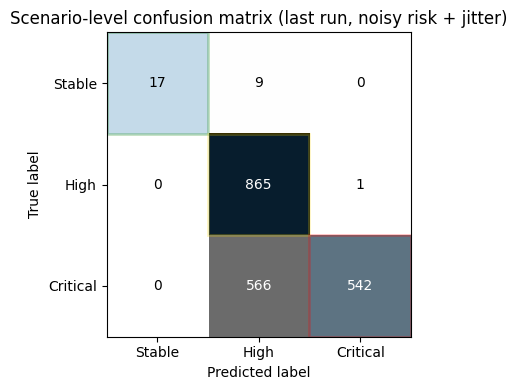

In [86]:
# ==============================================================================
# Scenario-based Fusion Evaluation (CICIoMT × VitalDB)
# Fixed thresholds (from canonical fusion cell) + multi-run robustness
# with risk noise + threshold jitter + coloured confusion matrix
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
    accuracy_score,
)
from tqdm.auto import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path

# ---------------- Safety checks ----------------
needed = [
    "security_model",
    "grouped_label_encoder",
    "X_sec_test_full",
    "y_sec_test_full",
    "clin_errors_full",
    "clinical_threshold",
    "X_cli_test_full",
    "FUSION_RISK_THR_STABLE",
    "FUSION_RISK_THR_CRITICAL",
    "compute_fusion_risk",
]
for name in needed:
    if name not in locals():
        raise RuntimeError(
            f"Required object '{name}' not found. "
            "Make sure you executed the canonical fusion cell first."
        )

# --- Rebuild security scores & flags (same logic as in fusion cell) ---
classes = list(grouped_label_encoder.classes_)
normal_label = None
for cand in classes:
    if "normal" in str(cand).lower():
        normal_label = cand
        break
if normal_label is None:
    counts = np.bincount(y_sec_test_full.astype(int))
    normal_idx = int(np.argmax(counts))
    normal_label = classes[normal_idx]
normal_idx = classes.index(normal_label)

proba_sec = security_model.predict_proba(X_sec_test_full)
sec_attack_score = 1.0 - proba_sec[:, normal_idx]
sec_attack_flag = (sec_attack_score >= 0.5).astype(int)

# --- Rebuild clinical severity & flags (same logic as in fusion cell) ---
clin_errors_full = np.asarray(clin_errors_full, dtype=float)
err_min = float(clin_errors_full.min())
err_max = float(clin_errors_full.max())
clin_severity_norm = (clin_errors_full - err_min) / (err_max - err_min)
clin_severity_norm = np.clip(clin_severity_norm, 0.0, 1.0)
clin_flag_full = (clin_errors_full > clinical_threshold).astype(int)

# ---------------- Helper: build fused pairs again ----------------
def build_fusion_pairs_eval(n_pairs: int, seed: int = 1234):
    rng = np.random.default_rng(seed)
    n_sec = X_sec_test_full.shape[0]
    n_cli = len(clin_severity_norm)

    sec_idx = rng.integers(0, n_sec, size=n_pairs)
    clin_idx = rng.integers(0, n_cli, size=n_pairs)

    sec_s = sec_attack_score[sec_idx]
    sec_f = sec_attack_flag[sec_idx]
    clin_s = clin_severity_norm[clin_idx]
    clin_f = clin_flag_full[clin_idx]

    risk_arr = np.array([compute_fusion_risk(s, c) for s, c in zip(sec_s, clin_s)])

    scenario_true = np.zeros_like(sec_f, dtype=int)
    scenario_true[(sec_f == 1) & (clin_f == 1)] = 2
    scenario_true[(sec_f != clin_f)] = 1

    return {
        "sec_score": sec_s,
        "sec_flag": sec_f,
        "clin_sev": clin_s,
        "clin_flag": clin_f,
        "risk": risk_arr,
        "scenario_true": scenario_true,
    }

# ---------------- Multi-run robustness evaluation ----------------
N_RUNS = 3
N_EVAL_PAIRS = 2000

# Risk noise (sensor / model uncertainty)
RISK_NOISE_STD = 0.06

# Threshold jitter (calibration uncertainty per deployment)
THR_NOISE_STD = 0.02

BASE_THR_STABLE = float(FUSION_RISK_THR_STABLE)
BASE_THR_CRITICAL = float(FUSION_RISK_THR_CRITICAL)

metrics_runs = []

print("\n=== Scenario-based fusion evaluation (fixed thresholds + noise + jitter) ===")
print(f"Base thresholds: Stable/High={BASE_THR_STABLE:.3f}, High/Critical={BASE_THR_CRITICAL:.3f}")
print(f"Evaluating over {N_RUNS} synthetic runs × {N_EVAL_PAIRS} fused cases each.")
print(f"Risk noise std (Gaussian)        = {RISK_NOISE_STD:.3f}")
print(f"Threshold jitter std (Gaussian)  = {THR_NOISE_STD:.3f}\n")

last_cm = None
last_thr_pair = None

for run_id in range(N_RUNS):
    seed = 3000 + run_id
    pairs_eval = build_fusion_pairs_eval(N_EVAL_PAIRS, seed=seed)
    risk_eval = pairs_eval["risk"]
    y_true = pairs_eval["scenario_true"]

    rng = np.random.default_rng(seed + 42)

    # Add Gaussian noise on risk
    if RISK_NOISE_STD > 0:
        noise = rng.normal(loc=0.0, scale=RISK_NOISE_STD, size=risk_eval.shape)
        risk_eval_used = np.clip(risk_eval + noise, 0.0, 1.0)
    else:
        risk_eval_used = risk_eval

    # Jitter thresholds run-by-run to simulate calibration uncertainty
    thr_s_run = np.clip(BASE_THR_STABLE + rng.normal(0.0, THR_NOISE_STD), 0.0, 1.0)
    thr_c_run = np.clip(BASE_THR_CRITICAL + rng.normal(0.0, THR_NOISE_STD), 0.0, 1.0)
    if thr_c_run <= thr_s_run + 0.02:
        thr_c_run = min(1.0, thr_s_run + 0.05)

    y_pred = np.where(
        risk_eval_used < thr_s_run, 0,
        np.where(risk_eval_used < thr_c_run, 1, 2)
    )

    prec, rec, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=[0, 1, 2], zero_division=0
    )
    acc = accuracy_score(y_true, y_pred)

    metrics_runs.append({
        "acc": acc,
        "prec_stable":   prec[0], "rec_stable":   rec[0], "f1_stable":   f1[0],
        "prec_high":     prec[1], "rec_high":     rec[1], "f1_high":     f1[1],
        "prec_critical": prec[2], "rec_critical": rec[2], "f1_critical": f1[2],
    })

    # Save confusion matrix of last run
    if run_id == N_RUNS - 1:
        last_cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
        last_thr_pair = (thr_s_run, thr_c_run)

df_runs = pd.DataFrame(metrics_runs)
print("\n=== Multi-run robustness over scenario sampling (3 runs, EVAL, 3-class) ===")
print(df_runs.describe().T[["mean", "std"]])

# ---------------- Plot confusion matrix with coloured diagonals ----------------
if last_cm is not None:
    fig, ax = plt.subplots(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=last_cm,
        display_labels=["Stable", "High", "Critical"]
    )
    disp.plot(ax=ax, colorbar=False, cmap="Greys")

    diag_colors = ["green", "gold", "red"]  # Stable, High, Critical
    for k, color in enumerate(diag_colors):
        rect = Rectangle(
            (k - 0.5, k - 0.5),
            1, 1,
            fill=True,
            alpha=0.25,
            edgecolor=color,
            linewidth=2
        )
        ax.add_patch(rect)

    ax.set_title("Scenario-level confusion matrix (last run, noisy risk + jitter)")
    plt.tight_layout()

    # Save the confusion matrix figure directly to the same /output folder
    PROJECT_DIR = Path("/content/drive/MyDrive/Conference_paper_ICCC_2026")
    OUTPUT_DIR = PROJECT_DIR / "output"
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    cm_path = OUTPUT_DIR / "fusion_scenario_confusion_matrix.png"
    fig.savefig(cm_path, dpi=300, bbox_inches="tight")
    print(f"\n[INFO] Confusion matrix figure saved to: {cm_path}")

    if last_thr_pair is not None:
        ts, tc = last_thr_pair
        print(f"[DEBUG] Last-run thresholds used: Stable/High={ts:.3f}, High/Critical={tc:.3f}")


[INFO] Clean security/clinical arrays ready for probabilistic fusion experiment.
  CICIoMT security samples: 2148250
  VitalDB clinical sequences: 37

[INFO] Built noisy fusion dataset (features with noise, labels from clean flags):
  Class 0 (Stable): 326 samples
  Class 1 (High): 13086 samples
  Class 2 (Critical): 16588 samples

[INFO] Fusion splits (stratified, noisy features):
  Train: 18000 samples
  Calib: 6000 samples
  Test : 6000 samples

=== Probabilistic fusion model (noisy features) on TEST fusion set ===
Accuracy: 0.9877

Stable   | P=0.9839 | R=0.9385 | F1=0.9606 | support=65
High     | P=0.9804 | R=0.9916 | F1=0.9859 | support=2617
Critical | P=0.9936 | R=0.9855 | F1=0.9896 | support=3318

Macro-F1: 0.9787

Detailed classification report:

              precision    recall  f1-score   support

      Stable       0.98      0.94      0.96        65
        High       0.98      0.99      0.99      2617
    Critical       0.99      0.99      0.99      3318

    accuracy    

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



[INFO] Probabilistic fusion confusion matrix (noisy features) saved to: /content/drive/MyDrive/Conference_paper_ICCC_2026/output/fusion_probabilistic_noisy_confusion_matrix.png


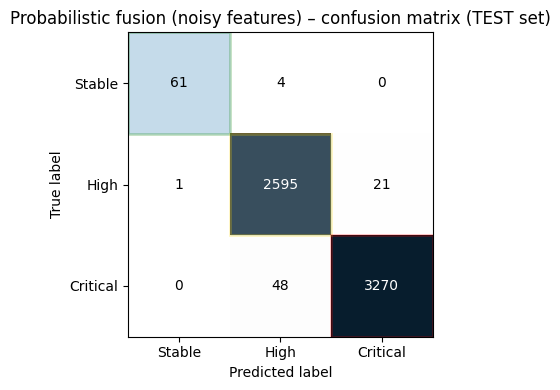

In [90]:
# ==============================================================================
# EXTRA EXPERIMENT (PROBABILISTIC FUSION RISK MODEL — NOISY FEATURES, TRAIN/CALIB/TEST)
#
# Goal:
#   - Build a synthetic fusion dataset (CICIoMT × VitalDB) with features derived
#     from *noisy* observations of the underlying anomaly scores.
#   - Ground-truth labels (Stable/High/Critical) are defined from the "clean"
#     sec_flag / clin_flag, representing latent true states.
#   - Train a 3-class probabilistic model (Logistic Regression) on noisy features.
#   - Calibrate probabilities on a separate calibration set (isotonic).
#   - Evaluate on an independent test set.
#
# Rationale:
#   In practice, the fusion engine does not see perfect anomaly scores; it sees
#   noisy measurements. This experiment introduces realistic uncertainty at the
#   feature level, while keeping the ground-truth "true" scenario labels fixed.
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle

# ---------------- Safety checks ----------------
needed = [
    "security_model",
    "grouped_label_encoder",
    "X_sec_test_full",
    "y_sec_test_full",
    "clin_errors_full",
    "clinical_threshold",
]
for name in needed:
    if name not in locals():
        raise RuntimeError(
            f"Required object '{name}' not found. Please run the main pipeline cells first."
        )

# ---------------- Rebuild security scores (clean) ----------------
classes = list(grouped_label_encoder.classes_)
normal_label = None
for cand in classes:
    if "normal" in str(cand).lower():
        normal_label = cand
        break
if normal_label is None:
    counts = np.bincount(y_sec_test_full.astype(int))
    normal_idx = int(np.argmax(counts))
    normal_label = classes[normal_idx]
normal_idx = classes.index(normal_label)

proba_sec = security_model.predict_proba(X_sec_test_full)
sec_attack_score_clean = 1.0 - proba_sec[:, normal_idx]
sec_attack_flag = (sec_attack_score_clean >= 0.5).astype(int)

# ---------------- Rebuild clinical severity (clean) ----------------
clin_errors_full = np.asarray(clin_errors_full, dtype=float)
err_min = float(clin_errors_full.min())
err_max = float(clin_errors_full.max())
clin_severity_norm_clean = (clin_errors_full - err_min) / (err_max - err_min)
clin_severity_norm_clean = np.clip(clin_severity_norm_clean, 0.0, 1.0)
clin_flag_full = (clin_errors_full > clinical_threshold).astype(int)

print("[INFO] Clean security/clinical arrays ready for probabilistic fusion experiment.")
print(f"  CICIoMT security samples: {X_sec_test_full.shape[0]}")
print(f"  VitalDB clinical sequences: {len(clin_severity_norm_clean)}")

# ---------------- Backup fusion risk if compute_fusion_risk is missing ----------------
def _default_compute_fusion_risk(sec_score_norm: float, clin_sev_norm: float) -> float:
    """
    Backup fusion risk: same structure as in the main notebook.
    Security has higher weight than clinical.
    """
    sec_score_norm = float(np.clip(sec_score_norm, 0.0, 1.0))
    clin_sev_norm = float(np.clip(clin_sev_norm, 0.0, 1.0))

    base = 0.10
    w_sec = 0.50
    w_clin = 0.30
    synergy = 0.10

    risk_raw = base + w_sec * sec_score_norm + w_clin * clin_sev_norm + synergy * sec_score_norm * clin_sev_norm
    return float(np.clip(risk_raw, 0.0, 1.0))

if "compute_fusion_risk" in locals():
    _fusion_fun = compute_fusion_risk
else:
    _fusion_fun = _default_compute_fusion_risk
    print("[WARN] 'compute_fusion_risk' not found. Using default backup fusion risk for this experiment.")

# ---------------- Build fusion dataset with noisy observations ----------------
def build_fusion_dataset_noisy(n_pairs: int = 30000,
                               seed: int = 2027,
                               noise_std_sec: float = 0.05,
                               noise_std_clin: float = 0.05):
    """
    Build a synthetic fusion dataset by randomly pairing:
      - CICIoMT security samples
      - VitalDB clinical samples

    Ground truth labels (3 classes) are based on CLEAN flags:
      y = 0  (Stable):   sec_flag_clean = 0 and clin_flag_clean = 0
      y = 1  (High):     sec_flag_clean != clin_flag_clean  (only one abnormal)
      y = 2  (Critical): sec_flag_clean = 1 and clin_flag_clean = 1

    Features given to the model are NOISY observations:
      X[:, 0] = sec_attack_score_obs     (clean + noise, clipped to [0,1])
      X[:, 1] = clin_severity_norm_obs   (clean + noise, clipped to [0,1])
      X[:, 2] = fused_risk_obs           (fusion risk computed from noisy scores)

    This simulates a realistic setting: the latent state is clean, but the
    fusion engine sees noisy measurements.
    """
    rng = np.random.default_rng(seed)

    n_sec = X_sec_test_full.shape[0]
    n_cli = len(clin_severity_norm_clean)

    # Random pairing indices
    sec_idx = rng.integers(0, n_sec, size=n_pairs)
    cli_idx = rng.integers(0, n_cli, size=n_pairs)

    # Clean underlying scores and flags
    sec_clean = sec_attack_score_clean[sec_idx]
    sec_flag = sec_attack_flag[sec_idx]

    clin_clean = clin_severity_norm_clean[cli_idx]
    clin_flag = clin_flag_full[cli_idx]

    # Ground-truth 3-class label from CLEAN flags
    y = np.zeros_like(sec_flag, dtype=int)
    y[(sec_flag == 1) & (clin_flag == 1)] = 2          # Critical
    y[(sec_flag != clin_flag)] = 1                     # High (only one abnormal)

    # Noisy observed scores
    sec_obs = sec_clean + rng.normal(0.0, noise_std_sec, size=sec_clean.shape)
    clin_obs = clin_clean + rng.normal(0.0, noise_std_clin, size=clin_clean.shape)

    sec_obs = np.clip(sec_obs, 0.0, 1.0)
    clin_obs = np.clip(clin_obs, 0.0, 1.0)

    # Fused risk on noisy scores (what the model would use internally)
    fused_risk_obs = np.array(
        [_fusion_fun(s, c) for s, c in zip(sec_obs, clin_obs)],
        dtype=float
    )

    # Final feature matrix
    X = np.column_stack([sec_obs, clin_obs, fused_risk_obs])

    return X, y

# You can adjust these noise std values to reflect plausible measurement noise
NOISE_STD_SEC = 0.05
NOISE_STD_CLIN = 0.05

N_PAIRS = 30000
X_fusion, y_fusion = build_fusion_dataset_noisy(
    n_pairs=N_PAIRS,
    seed=2027,
    noise_std_sec=NOISE_STD_SEC,
    noise_std_clin=NOISE_STD_CLIN,
)

print(f"\n[INFO] Built noisy fusion dataset (features with noise, labels from clean flags):")
unique, counts = np.unique(y_fusion, return_counts=True)
for v, c in zip(unique, counts):
    label = {0: "Stable", 1: "High", 2: "Critical"}.get(int(v), str(v))
    print(f"  Class {v} ({label}): {c} samples")

# ---------------- Split into train / calibration / test ----------------
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_fusion,
    y_fusion,
    test_size=0.40,
    random_state=2027,
    stratify=y_fusion,
)

X_calib, X_test, y_calib, y_test = train_test_split(
    X_tmp,
    y_tmp,
    test_size=0.50,
    random_state=2027,
    stratify=y_tmp,
)

print("\n[INFO] Fusion splits (stratified, noisy features):")
print(f"  Train: {X_train.shape[0]} samples")
print(f"  Calib: {X_calib.shape[0]} samples")
print(f"  Test : {X_test.shape[0]} samples")

# ---------------- Base multinomial model (3 classes) ----------------
base_clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=400,
)

base_clf.fit(X_train, y_train)

# ---------------- Probability calibration on calib set ----------------
calibrated_clf = CalibratedClassifierCV(
    base_clf,
    method="isotonic",
    cv="prefit",
)
calibrated_clf.fit(X_calib, y_calib)

# ---------------- Evaluation on test set ----------------
probs_test = calibrated_clf.predict_proba(X_test)
y_pred = np.argmax(probs_test, axis=1)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, support = precision_recall_fscore_support(
    y_test, y_pred, labels=[0, 1, 2], zero_division=0
)

print("\n=== Probabilistic fusion model (noisy features) on TEST fusion set ===")
print(f"Accuracy: {acc:.4f}\n")

for idx, name in zip([0, 1, 2], ["Stable", "High", "Critical"]):
    print(
        f"{name:<8} | P={prec[idx]:.4f} | R={rec[idx]:.4f} | F1={f1[idx]:.4f} | support={support[idx]}"
    )

macro_f1 = float(f1.mean())
print(f"\nMacro-F1: {macro_f1:.4f}\n")

print("Detailed classification report:\n")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=["Stable", "High", "Critical"],
        zero_division=0,
    )
)

# ---------------- Confusion matrix and figure export ----------------
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Stable", "High", "Critical"],
)
disp.plot(ax=ax, colorbar=False, cmap="Greys")

diag_colors = ["green", "gold", "red"]  # Stable, High, Critical
for k, color in enumerate(diag_colors):
    rect = Rectangle(
        (k - 0.5, k - 0.5),
        1,
        1,
        fill=True,
        alpha=0.25,
        edgecolor=color,
        linewidth=2,
    )
    ax.add_patch(rect)

ax.set_title("Probabilistic fusion (noisy features) – confusion matrix (TEST set)")
plt.tight_layout()

PROJECT_DIR = Path("/content/drive/MyDrive/Conference_paper_ICCC_2026")
OUTPUT_DIR = PROJECT_DIR / "output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

fig_path = OUTPUT_DIR / "fusion_probabilistic_noisy_confusion_matrix.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")
print(f"\n[INFO] Probabilistic fusion confusion matrix (noisy features) saved to: {fig_path}")


In [87]:
# ==============================================================================
# Export small DataFrames (tables) and matplotlib figures to Google Drive /output
# Project root: /content/drive/MyDrive/Conference_paper_ICCC_2026
# - Only DataFrames up to ~5 MB are exported (tables, not raw data)
# - All matplotlib figures are exported as PNG (dpi=300)
# ==============================================================================

import os
import re
from pathlib import Path

import matplotlib.pyplot as plt

try:
    import pandas as pd
except ImportError:
    pd = None  # Safety fallback

from tqdm.auto import tqdm

PROJECT_DIR = Path("/content/drive/MyDrive/Conference_paper_ICCC_2026")
OUTPUT_DIR = PROJECT_DIR / "output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

log_df = []
log_fig = []

# ------------------------------------------------------------------
# 1) Save only "small" pandas DataFrames as CSV (tables)
# ------------------------------------------------------------------
MAX_DF_BYTES = 5 * 1024 * 1024  # ≈ 5 MB in memory

if pd is not None:
    df_items = [
        (name, obj)
        for name, obj in list(globals().items())
        if isinstance(obj, pd.DataFrame)
    ]

    if len(df_items) == 0:
        print("No pandas DataFrames found in the current namespace.")
    else:
        print(f"Found {len(df_items)} DataFrames – exporting only small ones (≤ ~5 MB) to {OUTPUT_DIR} ...")
        for name, df in tqdm(df_items, desc="Saving small DataFrames"):
            approx_bytes = df.memory_usage(index=True, deep=True).sum()
            if approx_bytes > MAX_DF_BYTES:
                log_df.append(
                    f"[SKIP-LARGE] '{name}' not exported "
                    f"(~{approx_bytes / (1024*1024):.1f} MB)."
                )
                continue

            safe_name = re.sub(r"[^0-9a-zA-Z_]+", "_", name)
            out_path = OUTPUT_DIR / f"{safe_name}.csv"
            try:
                df.to_csv(out_path, index=False)
                log_df.append(f"[OK] '{name}' -> {out_path.name}")
            except Exception as e:
                log_df.append(f"[ERROR] '{name}' not saved: {e}")
else:
    print("pandas is not available; skipping DataFrame export.")

# ------------------------------------------------------------------
# 2) Save all current matplotlib figures
# ------------------------------------------------------------------
fig_nums = plt.get_fignums()
if len(fig_nums) == 0:
    print("No open matplotlib figures to export.")
else:
    print(f"Found {len(fig_nums)} matplotlib figures – exporting to {OUTPUT_DIR} ...")
    for num in tqdm(fig_nums, desc="Saving figures"):
        fig = plt.figure(num)
        out_path = OUTPUT_DIR / f"figure_{num}.png"
        try:
            fig.savefig(out_path, dpi=300, bbox_inches="tight")
            log_fig.append(f"[OK] Figure {num} -> {out_path.name}")
        except Exception as e:
            log_fig.append(f"[ERROR] Figure {num} not saved: {e}")

# ------------------------------------------------------------------
# 3) Write a small manifest with a summary of what was exported
# ------------------------------------------------------------------
manifest_path = OUTPUT_DIR / "export_manifest.txt"
with open(manifest_path, "w") as f:
    f.write("Export summary for this notebook run\n\n")
    f.write("=== DataFrames (tables) ===\n")
    for line in log_df:
        f.write(line + "\n")
    f.write("\n=== Figures ===\n")
    for line in log_fig:
        f.write(line + "\n")

print(f"\n✅ Export completed. Files saved under: {OUTPUT_DIR}")

print("\n=== DataFrames export log (up to 20 entries) ===")
print("\n".join(log_df[:20]))
if len(log_df) > 20:
    print(f"... ({len(log_df) - 20} more entries in export_manifest.txt)")

print("\n=== Figures export log (all entries) ===")
print("\n".join(log_fig) if log_fig else "(no figures found)")


Found 22 DataFrames – exporting only small ones (≤ ~5 MB) to /content/drive/MyDrive/Conference_paper_ICCC_2026/output ...


Saving small DataFrames:   0%|          | 0/22 [00:00<?, ?it/s]

No open matplotlib figures to export.

✅ Export completed. Files saved under: /content/drive/MyDrive/Conference_paper_ICCC_2026/output

=== DataFrames export log (up to 20 entries) ===
[OK] 'temp_df' -> temp_df.csv
[SKIP-LARGE] 'df' not exported (~792.2 MB).
[SKIP-LARGE] 'X' not exported (~792.2 MB).
[OK] 'importance_df' -> importance_df.csv
[OK] 'X_test_sample_shap' -> X_test_sample_shap.csv
[SKIP-LARGE] 'X_for_names' not exported (~792.2 MB).
[OK] 'X_test_sample_shap_iso' -> X_test_sample_shap_iso.csv
[OK] 'df_wide' -> df_wide.csv
[OK] 'group' -> group.csv
[OK] 'group_resampled' -> group_resampled.csv
[OK] 'group_imputed' -> group_imputed.csv
[OK] 'df_processed' -> df_processed.csv
[OK] 'error_df' -> error_df.csv
[OK] 'df_featured' -> df_featured.csv
[SKIP-LARGE] 'df_security' not exported (~2088.3 MB).
[SKIP-LARGE] 'X_sec' not exported (~792.2 MB).
[OK] 'df_clinical_featured' -> df_clinical_featured.csv
[OK] 'df_scenarios' -> df_scenarios.csv
[OK] 'df_eval_main' -> df_eval_main.csv
